<a href="https://colab.research.google.com/github/Keerthibalraj/Skin-cancer-segmentation/blob/main/Skin_cancer_segmentation_using_UNet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
from sklearn.utils import shuffle
H=128
W=128
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [33]:
def shuffling(x,y):
    x,y = shuffle(x,y,random_state=42)
    return x,y
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

Install the python library

In [34]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
# from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, add
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, normalize
#from keras_preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K
from IPython.display import display
import skimage.io
from skimage import io
import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from IPython.display import display

In [35]:
create_dir('files')
batch_size=16
lr=1e-4
num_epoch=5
model_path='/content/drive/MyDrive/kaggle/model.h5'
csv_path='/content/drive/MyDrive/kaggle/data.csv'

In [36]:
def load_data(dataset_path,split=0.2):
    images=sorted(glob(os.path.join(dataset_path,'images','*.jpg')))
    masks=sorted(glob(os.path.join(dataset_path,'masks','*.png')))
    test_size=int(len(images)*split)
    train_x,valid_x=train_test_split(images,test_size=test_size,random_state=42)
    train_y,valid_y=train_test_split(masks,test_size=test_size,random_state=42)
    train_x,test_x=train_test_split(train_x,test_size=test_size,random_state=42)
    train_y,test_y=train_test_split(train_y,test_size=test_size,random_state=42)
    return (train_x,train_y),(valid_x,valid_y),(test_x,test_y)

In [37]:
dataset_path='/content/drive/MyDrive/kaggle'
(train_x,train_y),(valid_x,valid_y),(test_x,test_y)= load_data(dataset_path)

Normalize images

In [38]:
def read_image(path):
    path=path.decode()
    x=cv2.imread(path,cv2.IMREAD_COLOR)
    x=cv2.resize(x,(W,H))
    x=x/255.0
    x=x.astype(np.float32)
    #x=np.expand_dims(x,axis=0)
    return x
def read_mask(path):
    path=path.decode()
    x=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    x=cv2.resize(x,(W,H))
    x=x/255.0
    x=x.astype(np.float32)
    X=np.expand_dims(x,axis=-1)
    x=np.expand_dims(x,axis=-1)
    return x
def tf_parse(x,y):
    def _parse(x,y):
        x=read_image(x)
        y=read_mask(y)
        return x,y
    x,y=tf.numpy_function(_parse,[x,y],[tf.float32,tf.float32])
    x.set_shape([H,W,3])
    y.set_shape([H,W,1])
    return x,y
def tf_dataset(X,Y,batch):
    dataset=tf.data.Dataset.from_tensor_slices((X,Y))
    dataset=dataset.map(tf_parse)
    dataset=dataset.batch(batch)
    dataset=dataset.prefetch(10)
    return dataset

In [39]:
train_dataset= tf_dataset(train_x,train_y,batch_size)
valid_dataset= tf_dataset(valid_x,valid_y,batch_size)

In [40]:
train_steps=len(train_x)//batch_size
valid_steps=len(valid_x)//batch_size
if len(train_x)%batch_size!=0:
    train_steps+=1
if len(valid_x)%batch_size!=0:
    valid_steps+=1
print(train_steps)

376


Sanity check

U-Net model

In [41]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    return model


In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [43]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision


In [44]:
IMG_HEIGHT = 128
IMG_WIDTH  = 128
IMG_CHANNELS = 3

def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = get_model()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 128, 128, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [45]:
callbacks=[
    ModelCheckpoint(model_path,verbose=1,save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
]

In [46]:
model.fit(
        train_dataset,
        epochs=num_epoch,
        validation_data=valid_dataset,
        steps_per_epoch=train_steps,
        validation_steps=valid_steps,
        callbacks=callbacks
    )

Epoch 1/5
376/376 [==============================] - ETA: 0s - loss: 0.2387 - accuracy: 0.8998
Epoch 1: val_loss improved from inf to 0.14886, saving model to /content/drive/MyDrive/kaggle/model.h5
376/376 [==============================] - 165s 385ms/step - loss: 0.2387 - accuracy: 0.8998 - val_loss: 0.1489 - val_accuracy: 0.9385 - lr: 0.0010
Epoch 2/5
376/376 [==============================] - ETA: 0s - loss: 0.1482 - accuracy: 0.9405
Epoch 2: val_loss improved from 0.14886 to 0.13530, saving model to /content/drive/MyDrive/kaggle/model.h5
376/376 [==============================] - 155s 413ms/step - loss: 0.1482 - accuracy: 0.9405 - val_loss: 0.1353 - val_accuracy: 0.9447 - lr: 0.0010
Epoch 3/5
376/376 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.9447
Epoch 3: val_loss improved from 0.13530 to 0.13064, saving model to /content/drive/MyDrive/kaggle/model.h5
376/376 [==============================] - 158s 421ms/step - loss: 0.1360 - accuracy: 0.9447 - val_los

Text(0.5, 1.0, 'Loss')

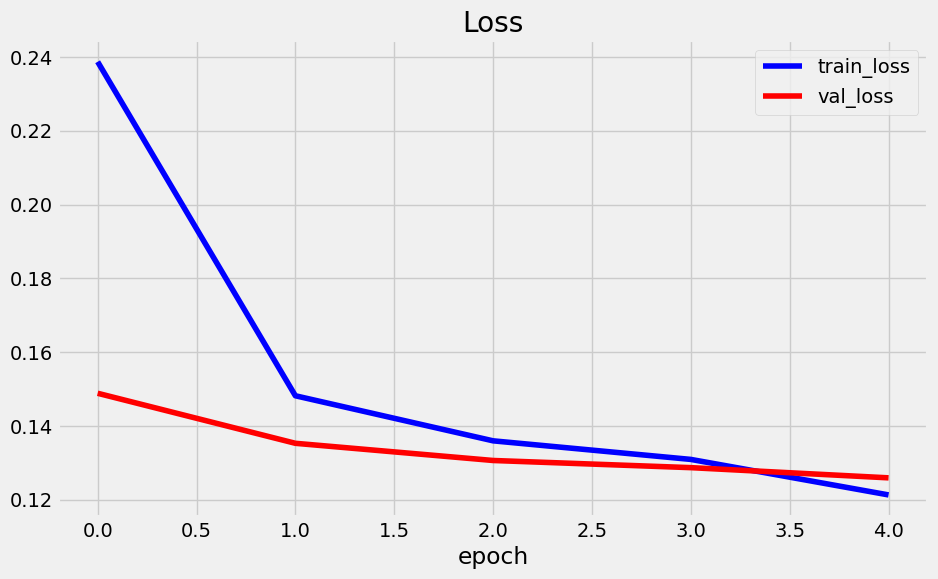

In [49]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,20))
plt.subplot(3,1,1)
plt.plot(model.history.history['loss'], 'b-', label='train_loss')
plt.plot(model.history.history['val_loss'], 'r-', label='val_loss')
plt.legend(loc='best')
plt.xlabel('epoch')
plt.title('Loss')




In [50]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score


H = 128
W = 128

def read_image1(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    return ori_x, x

def read_mask1(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

    cat_images = np.concatenate([ori_x, line, ori_y, line, y_pred*255], axis=1)
    cv2.imwrite(save_image_path, cat_images)


if __name__ == "__main__":

    np.random.seed(42)
    tf.random.set_seed(42)


    create_dir("results")
    with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef}):
        model = tf.keras.models.load_model("/content/drive/MyDrive/kaggle/model.h5")



    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Exctracting the image name """
        import warnings
        warnings.filterwarnings('always')
        name = x.split("/")[-1]

        """ Read the image and mask """
        ori_x, x = read_image1(x)
        ori_y, y = read_mask1(y)

        """ Predicting the mask """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = np.squeeze(y_pred, axis=-1)
        y_pred = y_pred.astype(np.int32)

        """ Saving the predicted mask """
        save_image_path = f"results/{name}"
        save_results(ori_x, ori_y, y_pred, save_image_path)

        """ Flattening the array """
        y = y.flatten()
        y_pred = y_pred.flatten()

        """ Calculating metrics values """
        acc_value = accuracy_score(y, y_pred)
        f1_value = f1_score(y, y_pred, labels=[0, 1], average="binary")
        jac_value = jaccard_score(y, y_pred, labels=[0, 1], average="binary")
        recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary")
        precision_value = precision_score(y, y_pred, labels=[0, 1], average="binary")
        SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])

    """ mean metrics values """
    score = [s[1:] for s in SCORE]
    score = np.mean(score, axis=0)
    print(f"Accuracy: {score[0]:0.5f}")
    print(f"F1: {score[1]:0.5f}")
    print(f"Jaccard: {score[2]:0.5f}")
    print(f"Recall: {score[3]:0.5f}")
    print(f"Precision: {score[4]:0.5f}")

    df = pd.DataFrame(SCORE, columns = ["Image Name", "Acc", "F1", "Jaccard", "Recall", "Precision"])
    df.to_csv("/content/drive/MyDrive/kaggle/Output.csv")

  0%|          | 0/2003 [00:00<?, ?it/s]<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; f

1/1 [==============================] - 2s 2s/step


  0%|          | 1/2003 [00:01<1:04:05,  1.92s/it]

1/1 [==============================] - 0s 22ms/step


  0%|          | 2/2003 [00:02<28:31,  1.17it/s]  

1/1 [==============================] - 0s 23ms/step


  0%|          | 3/2003 [00:02<17:07,  1.95it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 4/2003 [00:02<11:58,  2.78it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 5/2003 [00:02<09:02,  3.68it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 6/2003 [00:02<07:15,  4.58it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 7/2003 [00:02<06:12,  5.36it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 8/2003 [00:02<05:38,  5.89it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 9/2003 [00:02<05:12,  6.38it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 10/2003 [00:02<04:48,  6.90it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 11/2003 [00:03<04:30,  7.37it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 12/2003 [00:03<04:13,  7.84it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 13/2003 [00:03<04:07,  8.05it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 14/2003 [00:03<04:09,  7.98it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 15/2003 [00:03<04:08,  8.01it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 16/2003 [00:03<04:11,  7.91it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 17/2003 [00:03<04:14,  7.81it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 18/2003 [00:03<04:09,  7.94it/s]

1/1 [==============================] - 0s 31ms/step


  1%|          | 19/2003 [00:04<04:05,  8.09it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 20/2003 [00:04<03:54,  8.44it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 21/2003 [00:04<03:50,  8.60it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 22/2003 [00:04<03:49,  8.64it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 23/2003 [00:04<03:47,  8.69it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 24/2003 [00:04<03:50,  8.59it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 25/2003 [00:04<03:54,  8.43it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 26/2003 [00:04<04:03,  8.13it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 27/2003 [00:05<04:10,  7.89it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 28/2003 [00:05<04:37,  7.12it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 29/2003 [00:05<04:57,  6.64it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 30/2003 [00:05<05:03,  6.49it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 31/2003 [00:05<05:09,  6.38it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 32/2003 [00:05<05:16,  6.23it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 33/2003 [00:06<05:31,  5.95it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 34/2003 [00:06<05:35,  5.87it/s]

1/1 [==============================] - 0s 34ms/step


  2%|▏         | 35/2003 [00:06<05:30,  5.95it/s]

1/1 [==============================] - 0s 42ms/step


  2%|▏         | 36/2003 [00:06<05:35,  5.86it/s]

1/1 [==============================] - 0s 43ms/step


  2%|▏         | 37/2003 [00:06<05:45,  5.69it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 38/2003 [00:06<05:41,  5.76it/s]

1/1 [==============================] - 0s 37ms/step


  2%|▏         | 39/2003 [00:07<05:34,  5.87it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 40/2003 [00:07<05:33,  5.88it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 41/2003 [00:07<05:36,  5.83it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 42/2003 [00:07<05:24,  6.04it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 43/2003 [00:07<05:35,  5.84it/s]

1/1 [==============================] - 0s 32ms/step


  2%|▏         | 44/2003 [00:07<05:33,  5.87it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 45/2003 [00:08<05:34,  5.85it/s]

1/1 [==============================] - 0s 35ms/step


  2%|▏         | 46/2003 [00:08<05:28,  5.96it/s]

1/1 [==============================] - 0s 33ms/step


  2%|▏         | 47/2003 [00:08<05:29,  5.93it/s]

1/1 [==============================] - 0s 36ms/step


  2%|▏         | 48/2003 [00:08<05:32,  5.88it/s]

1/1 [==============================] - 0s 38ms/step


  2%|▏         | 49/2003 [00:08<05:28,  5.94it/s]

1/1 [==============================] - 0s 41ms/step


  2%|▏         | 50/2003 [00:08<05:38,  5.76it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 51/2003 [00:09<05:32,  5.87it/s]

1/1 [==============================] - 0s 36ms/step


  3%|▎         | 52/2003 [00:09<05:34,  5.83it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 53/2003 [00:09<05:04,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 54/2003 [00:09<04:39,  6.96it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 55/2003 [00:09<04:23,  7.40it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 56/2003 [00:09<04:18,  7.54it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 57/2003 [00:09<04:08,  7.84it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 58/2003 [00:10<04:04,  7.97it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 59/2003 [00:10<03:54,  8.28it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 60/2003 [00:10<03:48,  8.52it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 61/2003 [00:10<03:54,  8.27it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 62/2003 [00:10<03:52,  8.35it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 63/2003 [00:10<04:05,  7.90it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 64/2003 [00:10<04:04,  7.92it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 65/2003 [00:10<04:03,  7.96it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 66/2003 [00:11<03:58,  8.10it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 67/2003 [00:11<03:49,  8.43it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 68/2003 [00:11<03:45,  8.56it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 69/2003 [00:11<03:46,  8.55it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 70/2003 [00:11<03:47,  8.50it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 71/2003 [00:11<03:44,  8.61it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 72/2003 [00:11<03:44,  8.60it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 73/2003 [00:11<03:48,  8.46it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 74/2003 [00:11<03:58,  8.10it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 75/2003 [00:12<03:57,  8.13it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 76/2003 [00:12<03:51,  8.34it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 77/2003 [00:12<03:52,  8.28it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 78/2003 [00:12<03:57,  8.10it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 79/2003 [00:12<03:56,  8.13it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 80/2003 [00:12<03:51,  8.30it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 81/2003 [00:12<03:48,  8.43it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 82/2003 [00:12<03:44,  8.57it/s]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 83/2003 [00:13<03:51,  8.30it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 84/2003 [00:13<03:45,  8.49it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 85/2003 [00:13<03:44,  8.55it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 86/2003 [00:13<03:41,  8.64it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 87/2003 [00:13<03:45,  8.49it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 88/2003 [00:13<03:46,  8.45it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 89/2003 [00:13<03:45,  8.49it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 90/2003 [00:13<03:43,  8.57it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▍         | 91/2003 [00:13<03:38,  8.75it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 92/2003 [00:14<03:40,  8.66it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 93/2003 [00:14<03:38,  8.73it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 94/2003 [00:14<03:37,  8.76it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 95/2003 [00:14<03:45,  8.47it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 96/2003 [00:14<03:43,  8.53it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 97/2003 [00:14<03:46,  8.42it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 98/2003 [00:14<03:46,  8.41it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 99/2003 [00:14<03:50,  8.25it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 100/2003 [00:15<03:55,  8.07it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 101/2003 [00:15<03:52,  8.18it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 102/2003 [00:15<03:48,  8.30it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 103/2003 [00:15<03:50,  8.25it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 104/2003 [00:15<03:45,  8.41it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 105/2003 [00:15<03:47,  8.36it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 106/2003 [00:15<03:46,  8.37it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 107/2003 [00:15<03:44,  8.46it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 108/2003 [00:15<03:43,  8.49it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 109/2003 [00:16<03:47,  8.33it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▌         | 110/2003 [00:16<03:38,  8.67it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 111/2003 [00:16<03:34,  8.81it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 112/2003 [00:16<03:35,  8.76it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 113/2003 [00:16<03:41,  8.53it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 114/2003 [00:16<03:43,  8.44it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 115/2003 [00:16<03:39,  8.61it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 116/2003 [00:16<03:40,  8.56it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 117/2003 [00:17<03:45,  8.37it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 118/2003 [00:17<03:48,  8.24it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 119/2003 [00:17<03:40,  8.53it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 120/2003 [00:17<03:38,  8.63it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 121/2003 [00:17<03:41,  8.51it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 122/2003 [00:17<03:55,  8.00it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 123/2003 [00:17<03:50,  8.16it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 124/2003 [00:17<03:46,  8.29it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 125/2003 [00:17<03:44,  8.37it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 126/2003 [00:18<03:48,  8.22it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▋         | 127/2003 [00:18<03:44,  8.34it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 128/2003 [00:18<03:46,  8.27it/s]

1/1 [==============================] - 0s 23ms/step


  6%|▋         | 129/2003 [00:18<03:48,  8.18it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 130/2003 [00:18<03:48,  8.18it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 131/2003 [00:18<03:50,  8.13it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 132/2003 [00:18<03:51,  8.07it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 133/2003 [00:18<03:48,  8.19it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 134/2003 [00:19<03:47,  8.22it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 135/2003 [00:19<03:47,  8.19it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 136/2003 [00:19<03:58,  7.82it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 137/2003 [00:19<04:23,  7.09it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 138/2003 [00:19<04:29,  6.91it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 139/2003 [00:19<04:47,  6.48it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 140/2003 [00:20<05:05,  6.10it/s]

1/1 [==============================] - 0s 51ms/step


  7%|▋         | 141/2003 [00:20<05:23,  5.76it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 142/2003 [00:20<05:24,  5.74it/s]

1/1 [==============================] - 0s 33ms/step


  7%|▋         | 143/2003 [00:20<05:25,  5.71it/s]

1/1 [==============================] - 0s 96ms/step


  7%|▋         | 144/2003 [00:20<07:08,  4.34it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 145/2003 [00:21<06:43,  4.60it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 146/2003 [00:21<06:23,  4.84it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 147/2003 [00:21<06:10,  5.01it/s]

1/1 [==============================] - 0s 35ms/step


  7%|▋         | 148/2003 [00:21<05:55,  5.22it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 149/2003 [00:21<05:53,  5.25it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 150/2003 [00:22<05:49,  5.31it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 151/2003 [00:22<05:35,  5.52it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 152/2003 [00:22<05:32,  5.57it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 153/2003 [00:22<05:35,  5.51it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 154/2003 [00:22<05:23,  5.71it/s]

1/1 [==============================] - 0s 45ms/step


  8%|▊         | 155/2003 [00:22<05:27,  5.64it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 156/2003 [00:23<05:23,  5.70it/s]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 157/2003 [00:23<05:16,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 158/2003 [00:23<05:16,  5.83it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 159/2003 [00:23<05:17,  5.80it/s]

1/1 [==============================] - 0s 35ms/step


  8%|▊         | 160/2003 [00:23<05:07,  6.00it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 161/2003 [00:23<04:59,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 162/2003 [00:24<04:39,  6.58it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 163/2003 [00:24<04:23,  6.99it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 164/2003 [00:24<04:08,  7.41it/s]

1/1 [==============================] - 0s 37ms/step


  8%|▊         | 165/2003 [00:24<04:02,  7.58it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 166/2003 [00:24<04:00,  7.63it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 167/2003 [00:24<03:58,  7.71it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 168/2003 [00:24<03:56,  7.75it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 169/2003 [00:24<03:49,  7.98it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 170/2003 [00:25<03:45,  8.14it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 171/2003 [00:25<03:43,  8.21it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▊         | 172/2003 [00:25<03:38,  8.38it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 173/2003 [00:25<03:38,  8.39it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▊         | 174/2003 [00:25<03:40,  8.30it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▊         | 175/2003 [00:25<03:44,  8.15it/s]

1/1 [==============================] - 0s 35ms/step


  9%|▉         | 176/2003 [00:25<03:45,  8.08it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 177/2003 [00:25<03:41,  8.23it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 178/2003 [00:25<03:41,  8.26it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 179/2003 [00:26<03:34,  8.50it/s]

1/1 [==============================] - 0s 22ms/step


  9%|▉         | 180/2003 [00:26<03:29,  8.71it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 181/2003 [00:26<03:27,  8.77it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 182/2003 [00:26<03:37,  8.38it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 183/2003 [00:26<03:37,  8.39it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 184/2003 [00:26<03:44,  8.10it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 185/2003 [00:26<03:46,  8.04it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 186/2003 [00:26<03:48,  7.97it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 187/2003 [00:27<03:45,  8.07it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 188/2003 [00:27<03:37,  8.33it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 189/2003 [00:27<03:32,  8.55it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 190/2003 [00:27<03:34,  8.47it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 191/2003 [00:27<03:36,  8.37it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 192/2003 [00:27<03:35,  8.39it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 193/2003 [00:27<03:43,  8.08it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 194/2003 [00:27<03:38,  8.29it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 195/2003 [00:28<03:41,  8.15it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 196/2003 [00:28<03:40,  8.21it/s]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 197/2003 [00:28<03:34,  8.43it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 198/2003 [00:28<03:34,  8.40it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 199/2003 [00:28<03:40,  8.19it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 200/2003 [00:28<03:42,  8.11it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 201/2003 [00:28<03:36,  8.32it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 202/2003 [00:28<03:36,  8.30it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 203/2003 [00:28<03:39,  8.19it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 204/2003 [00:29<03:40,  8.15it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 205/2003 [00:29<03:34,  8.36it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 206/2003 [00:29<03:31,  8.49it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 207/2003 [00:29<03:26,  8.72it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 208/2003 [00:29<03:36,  8.30it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 209/2003 [00:29<03:35,  8.33it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 210/2003 [00:29<03:34,  8.36it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 211/2003 [00:29<03:43,  8.02it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 212/2003 [00:30<03:41,  8.09it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 213/2003 [00:30<03:41,  8.08it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 214/2003 [00:30<03:42,  8.04it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 215/2003 [00:30<03:37,  8.23it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 216/2003 [00:30<03:39,  8.14it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 217/2003 [00:30<03:43,  7.99it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 218/2003 [00:30<03:39,  8.15it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 219/2003 [00:30<03:38,  8.18it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 220/2003 [00:31<03:39,  8.11it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 221/2003 [00:31<03:33,  8.34it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 222/2003 [00:31<03:30,  8.46it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 223/2003 [00:31<03:30,  8.47it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 224/2003 [00:31<03:29,  8.49it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 225/2003 [00:31<03:32,  8.38it/s]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 226/2003 [00:31<03:48,  7.78it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 227/2003 [00:31<03:45,  7.86it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 228/2003 [00:32<03:45,  7.87it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 229/2003 [00:32<03:40,  8.03it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 230/2003 [00:32<03:37,  8.14it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 231/2003 [00:32<03:34,  8.25it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 232/2003 [00:32<03:31,  8.36it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 233/2003 [00:32<03:39,  8.08it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 234/2003 [00:32<03:35,  8.20it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 235/2003 [00:32<03:37,  8.13it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 236/2003 [00:33<03:36,  8.16it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 237/2003 [00:33<03:41,  7.99it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 238/2003 [00:33<03:38,  8.09it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 239/2003 [00:33<03:43,  7.89it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 240/2003 [00:33<03:38,  8.06it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 241/2003 [00:33<03:44,  7.86it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 242/2003 [00:33<03:36,  8.12it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 243/2003 [00:33<03:36,  8.13it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 244/2003 [00:34<03:59,  7.35it/s]

1/1 [==============================] - 0s 36ms/step


 12%|█▏        | 245/2003 [00:34<04:21,  6.73it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 246/2003 [00:34<04:47,  6.12it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 247/2003 [00:34<04:54,  5.97it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 248/2003 [00:34<04:51,  6.02it/s]

1/1 [==============================] - 0s 34ms/step


 12%|█▏        | 249/2003 [00:34<04:50,  6.03it/s]

1/1 [==============================] - 0s 33ms/step


 12%|█▏        | 250/2003 [00:35<04:47,  6.09it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 251/2003 [00:35<04:49,  6.05it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 252/2003 [00:35<04:56,  5.91it/s]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 253/2003 [00:35<04:53,  5.96it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 254/2003 [00:35<05:07,  5.69it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 255/2003 [00:36<05:15,  5.53it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 256/2003 [00:36<05:08,  5.66it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 257/2003 [00:36<05:07,  5.68it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 258/2003 [00:36<05:12,  5.59it/s]

1/1 [==============================] - 0s 42ms/step


 13%|█▎        | 259/2003 [00:36<05:05,  5.71it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 260/2003 [00:36<05:11,  5.60it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 261/2003 [00:37<05:09,  5.62it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 262/2003 [00:37<05:05,  5.70it/s]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 263/2003 [00:37<05:03,  5.74it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 264/2003 [00:37<05:10,  5.59it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 265/2003 [00:37<05:16,  5.49it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 266/2003 [00:37<05:26,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 267/2003 [00:38<05:23,  5.37it/s]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 268/2003 [00:38<05:16,  5.49it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 269/2003 [00:38<04:40,  6.19it/s]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 270/2003 [00:38<04:16,  6.76it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▎        | 271/2003 [00:38<04:06,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 272/2003 [00:38<03:54,  7.39it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 273/2003 [00:38<03:55,  7.34it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 274/2003 [00:39<03:43,  7.75it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▎        | 275/2003 [00:39<03:40,  7.83it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 276/2003 [00:39<03:37,  7.93it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 277/2003 [00:39<03:31,  8.14it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 278/2003 [00:39<03:28,  8.26it/s]

1/1 [==============================] - 0s 33ms/step


 14%|█▍        | 279/2003 [00:39<03:31,  8.15it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 280/2003 [00:39<03:30,  8.18it/s]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 281/2003 [00:39<03:37,  7.91it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 282/2003 [00:40<03:31,  8.13it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 283/2003 [00:40<03:27,  8.28it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 284/2003 [00:40<03:26,  8.32it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 285/2003 [00:40<03:28,  8.25it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 286/2003 [00:40<03:31,  8.10it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 287/2003 [00:40<03:30,  8.16it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 288/2003 [00:40<03:32,  8.06it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 289/2003 [00:40<03:40,  7.76it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 290/2003 [00:41<03:41,  7.72it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 291/2003 [00:41<03:38,  7.85it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 292/2003 [00:41<03:36,  7.91it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 293/2003 [00:41<03:35,  7.94it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 294/2003 [00:41<03:29,  8.14it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 295/2003 [00:41<03:29,  8.16it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 296/2003 [00:41<03:30,  8.10it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 297/2003 [00:41<03:32,  8.04it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▍        | 298/2003 [00:42<03:37,  7.82it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 299/2003 [00:42<03:36,  7.86it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 300/2003 [00:42<03:34,  7.94it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 301/2003 [00:42<03:37,  7.83it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 302/2003 [00:42<03:37,  7.83it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 303/2003 [00:42<03:33,  7.98it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 304/2003 [00:42<03:26,  8.24it/s]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 305/2003 [00:42<03:27,  8.18it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 306/2003 [00:43<03:32,  7.99it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 307/2003 [00:43<03:30,  8.05it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 308/2003 [00:43<03:31,  8.02it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 309/2003 [00:43<03:30,  8.05it/s]

1/1 [==============================] - 0s 37ms/step


 15%|█▌        | 310/2003 [00:43<03:34,  7.90it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 311/2003 [00:43<03:31,  8.00it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 312/2003 [00:43<03:27,  8.17it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 313/2003 [00:43<03:26,  8.17it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 314/2003 [00:44<03:29,  8.05it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 315/2003 [00:44<03:28,  8.10it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▌        | 316/2003 [00:44<03:24,  8.25it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 317/2003 [00:44<03:31,  7.96it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 318/2003 [00:44<03:25,  8.22it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 319/2003 [00:44<03:26,  8.16it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 320/2003 [00:44<03:27,  8.13it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 321/2003 [00:44<03:23,  8.28it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 322/2003 [00:45<03:28,  8.04it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 323/2003 [00:45<03:25,  8.19it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 324/2003 [00:45<03:25,  8.16it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 325/2003 [00:45<03:24,  8.22it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 326/2003 [00:45<03:31,  7.92it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▋        | 327/2003 [00:45<03:30,  7.97it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 328/2003 [00:45<03:26,  8.09it/s]

1/1 [==============================] - 0s 25ms/step


 16%|█▋        | 329/2003 [00:45<03:27,  8.06it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 330/2003 [00:45<03:25,  8.15it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 331/2003 [00:46<03:26,  8.08it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 332/2003 [00:46<03:24,  8.19it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 333/2003 [00:46<03:27,  8.06it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 334/2003 [00:46<03:22,  8.25it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 335/2003 [00:46<03:23,  8.21it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 336/2003 [00:46<03:26,  8.09it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 337/2003 [00:46<03:25,  8.12it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 338/2003 [00:46<03:26,  8.08it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 339/2003 [00:47<03:37,  7.65it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 340/2003 [00:47<03:30,  7.89it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 341/2003 [00:47<03:28,  7.98it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 342/2003 [00:47<03:22,  8.21it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 343/2003 [00:47<03:16,  8.47it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 344/2003 [00:47<03:18,  8.34it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 345/2003 [00:47<03:30,  7.88it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 346/2003 [00:47<03:29,  7.90it/s]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 347/2003 [00:48<03:29,  7.92it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 348/2003 [00:48<03:24,  8.09it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 349/2003 [00:48<03:18,  8.32it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 350/2003 [00:48<03:46,  7.30it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 351/2003 [00:48<04:03,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 352/2003 [00:48<04:18,  6.40it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 353/2003 [00:49<04:28,  6.13it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 354/2003 [00:49<04:37,  5.94it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 355/2003 [00:49<04:36,  5.97it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 356/2003 [00:49<04:42,  5.83it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 357/2003 [00:49<04:45,  5.76it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 358/2003 [00:49<04:47,  5.72it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 359/2003 [00:50<04:51,  5.63it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 360/2003 [00:50<04:51,  5.63it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 361/2003 [00:50<04:47,  5.70it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 362/2003 [00:50<04:49,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 18%|█▊        | 363/2003 [00:50<04:53,  5.60it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 364/2003 [00:51<04:55,  5.55it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 365/2003 [00:51<04:48,  5.67it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 366/2003 [00:51<04:51,  5.62it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 367/2003 [00:51<04:47,  5.68it/s]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 368/2003 [00:51<04:42,  5.78it/s]

1/1 [==============================] - 0s 36ms/step


 18%|█▊        | 369/2003 [00:51<04:45,  5.72it/s]

1/1 [==============================] - 0s 35ms/step


 18%|█▊        | 370/2003 [00:52<04:48,  5.67it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▊        | 371/2003 [00:52<04:49,  5.64it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 372/2003 [00:52<04:56,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 19%|█▊        | 373/2003 [00:52<04:52,  5.57it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 374/2003 [00:52<04:45,  5.70it/s]

1/1 [==============================] - 0s 34ms/step


 19%|█▊        | 375/2003 [00:52<04:45,  5.70it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 376/2003 [00:53<04:27,  6.07it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 377/2003 [00:53<04:05,  6.62it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 378/2003 [00:53<03:56,  6.88it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 379/2003 [00:53<03:46,  7.17it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 380/2003 [00:53<03:38,  7.43it/s]

1/1 [==============================] - 0s 33ms/step


 19%|█▉        | 381/2003 [00:53<03:36,  7.49it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 382/2003 [00:53<03:31,  7.66it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 383/2003 [00:53<03:29,  7.73it/s]

1/1 [==============================] - 0s 23ms/step


 19%|█▉        | 384/2003 [00:54<03:26,  7.85it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 385/2003 [00:54<03:27,  7.79it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 386/2003 [00:54<03:30,  7.67it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 387/2003 [00:54<03:23,  7.95it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 388/2003 [00:54<03:29,  7.73it/s]

1/1 [==============================] - 0s 28ms/step


 19%|█▉        | 389/2003 [00:54<03:33,  7.55it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 390/2003 [00:54<03:30,  7.66it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 391/2003 [00:54<03:25,  7.83it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 392/2003 [00:55<03:22,  7.95it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 393/2003 [00:55<03:21,  7.98it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 394/2003 [00:55<03:30,  7.63it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 395/2003 [00:55<03:27,  7.76it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 396/2003 [00:55<03:26,  7.79it/s]

1/1 [==============================] - 0s 30ms/step


 20%|█▉        | 397/2003 [00:55<03:32,  7.56it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 398/2003 [00:55<03:33,  7.52it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 399/2003 [00:56<03:25,  7.82it/s]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 400/2003 [00:56<03:22,  7.92it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 401/2003 [00:56<03:19,  8.03it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 402/2003 [00:56<03:25,  7.80it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 403/2003 [00:56<03:21,  7.96it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 404/2003 [00:56<03:20,  7.98it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 405/2003 [00:56<03:19,  8.02it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 406/2003 [00:56<03:24,  7.82it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 407/2003 [00:57<03:30,  7.58it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 408/2003 [00:57<03:25,  7.77it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 409/2003 [00:57<03:20,  7.95it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 410/2003 [00:57<03:21,  7.90it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 411/2003 [00:57<03:21,  7.89it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 412/2003 [00:57<03:21,  7.90it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 413/2003 [00:57<03:20,  7.92it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 414/2003 [00:57<03:17,  8.03it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 415/2003 [00:58<03:20,  7.90it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 416/2003 [00:58<03:19,  7.96it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 417/2003 [00:58<03:18,  7.98it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 418/2003 [00:58<03:19,  7.96it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 419/2003 [00:58<03:17,  8.03it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 420/2003 [00:58<03:21,  7.87it/s]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 421/2003 [00:58<03:20,  7.90it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 422/2003 [00:58<03:19,  7.91it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 423/2003 [00:59<03:21,  7.85it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 424/2003 [00:59<03:19,  7.92it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 425/2003 [00:59<03:15,  8.05it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██▏       | 426/2003 [00:59<03:15,  8.05it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 427/2003 [00:59<03:21,  7.84it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 428/2003 [00:59<03:16,  8.01it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 429/2003 [00:59<03:15,  8.06it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 430/2003 [00:59<03:16,  8.02it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 431/2003 [01:00<03:14,  8.09it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 432/2003 [01:00<03:16,  8.01it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 433/2003 [01:00<03:18,  7.89it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 434/2003 [01:00<03:18,  7.90it/s]

1/1 [==============================] - 0s 31ms/step


 22%|██▏       | 435/2003 [01:00<03:19,  7.85it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 436/2003 [01:00<03:21,  7.76it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 437/2003 [01:00<03:23,  7.70it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 438/2003 [01:00<03:23,  7.70it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 439/2003 [01:01<03:18,  7.88it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 440/2003 [01:01<03:17,  7.91it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 441/2003 [01:01<03:22,  7.69it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 442/2003 [01:01<03:20,  7.77it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 443/2003 [01:01<03:23,  7.67it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 444/2003 [01:01<03:18,  7.86it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 445/2003 [01:01<03:17,  7.88it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 446/2003 [01:01<03:15,  7.97it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 447/2003 [01:02<03:09,  8.21it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 448/2003 [01:02<03:06,  8.34it/s]

1/1 [==============================] - 0s 23ms/step


 22%|██▏       | 449/2003 [01:02<03:08,  8.25it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 450/2003 [01:02<03:13,  8.02it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 451/2003 [01:02<03:19,  7.77it/s]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 452/2003 [01:02<03:16,  7.91it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 453/2003 [01:02<03:14,  7.98it/s]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 454/2003 [01:02<03:18,  7.80it/s]

1/1 [==============================] - 0s 48ms/step


 23%|██▎       | 455/2003 [01:03<03:46,  6.83it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 456/2003 [01:03<04:01,  6.40it/s]

1/1 [==============================] - 0s 40ms/step


 23%|██▎       | 457/2003 [01:03<04:11,  6.14it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 458/2003 [01:03<04:19,  5.95it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 459/2003 [01:03<04:21,  5.91it/s]

1/1 [==============================] - 0s 39ms/step


 23%|██▎       | 460/2003 [01:04<04:22,  5.88it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 461/2003 [01:04<04:22,  5.87it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 462/2003 [01:04<04:29,  5.72it/s]

1/1 [==============================] - 0s 38ms/step


 23%|██▎       | 463/2003 [01:04<04:33,  5.63it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 464/2003 [01:04<04:40,  5.49it/s]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 465/2003 [01:04<04:41,  5.46it/s]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 466/2003 [01:05<04:34,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 23%|██▎       | 467/2003 [01:05<04:33,  5.62it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 468/2003 [01:05<04:35,  5.58it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 469/2003 [01:05<04:28,  5.72it/s]

1/1 [==============================] - 0s 35ms/step


 23%|██▎       | 470/2003 [01:05<04:29,  5.68it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 471/2003 [01:06<04:37,  5.52it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 472/2003 [01:06<04:41,  5.44it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▎       | 473/2003 [01:06<04:39,  5.48it/s]

1/1 [==============================] - 0s 34ms/step


 24%|██▎       | 474/2003 [01:06<04:32,  5.61it/s]

1/1 [==============================] - 0s 33ms/step


 24%|██▎       | 475/2003 [01:06<04:32,  5.61it/s]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 476/2003 [01:06<04:43,  5.39it/s]

1/1 [==============================] - 0s 37ms/step


 24%|██▍       | 477/2003 [01:07<04:41,  5.41it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 478/2003 [01:07<04:33,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 479/2003 [01:07<04:31,  5.61it/s]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 480/2003 [01:07<04:33,  5.56it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 481/2003 [01:07<04:25,  5.73it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 482/2003 [01:07<04:05,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 483/2003 [01:08<03:46,  6.72it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 484/2003 [01:08<03:36,  7.03it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 485/2003 [01:08<03:22,  7.50it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 486/2003 [01:08<03:20,  7.56it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 487/2003 [01:08<03:25,  7.39it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 488/2003 [01:08<03:21,  7.50it/s]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 489/2003 [01:08<03:23,  7.44it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 490/2003 [01:08<03:18,  7.61it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 491/2003 [01:09<03:12,  7.85it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 492/2003 [01:09<03:11,  7.89it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▍       | 493/2003 [01:09<03:11,  7.88it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▍       | 494/2003 [01:09<03:12,  7.86it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 495/2003 [01:09<03:12,  7.84it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 496/2003 [01:09<03:14,  7.76it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 497/2003 [01:09<03:18,  7.58it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▍       | 498/2003 [01:09<03:16,  7.65it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 499/2003 [01:10<03:12,  7.80it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▍       | 500/2003 [01:10<03:08,  7.95it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 501/2003 [01:10<03:08,  7.95it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 502/2003 [01:10<03:09,  7.92it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 503/2003 [01:10<03:12,  7.81it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 504/2003 [01:10<03:12,  7.78it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 505/2003 [01:10<03:17,  7.60it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 506/2003 [01:11<03:13,  7.73it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 507/2003 [01:11<03:08,  7.92it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 508/2003 [01:11<03:03,  8.15it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 509/2003 [01:11<03:02,  8.18it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 510/2003 [01:11<03:02,  8.16it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 511/2003 [01:11<03:07,  7.95it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 512/2003 [01:11<03:10,  7.81it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 513/2003 [01:11<03:09,  7.87it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▌       | 514/2003 [01:12<03:14,  7.65it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 515/2003 [01:12<03:11,  7.76it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 516/2003 [01:12<03:09,  7.83it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 517/2003 [01:12<03:08,  7.90it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 518/2003 [01:12<03:05,  8.00it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 519/2003 [01:12<03:08,  7.89it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 520/2003 [01:12<03:10,  7.78it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 521/2003 [01:12<03:12,  7.70it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 522/2003 [01:13<03:18,  7.47it/s]

1/1 [==============================] - 0s 24ms/step


 26%|██▌       | 523/2003 [01:13<03:12,  7.67it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 524/2003 [01:13<03:11,  7.72it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 525/2003 [01:13<03:13,  7.64it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 526/2003 [01:13<03:11,  7.72it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 527/2003 [01:13<03:14,  7.58it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 528/2003 [01:13<03:19,  7.41it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 529/2003 [01:13<03:20,  7.35it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 530/2003 [01:14<03:15,  7.54it/s]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 531/2003 [01:14<03:16,  7.49it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 532/2003 [01:14<03:13,  7.61it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 533/2003 [01:14<03:11,  7.67it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 534/2003 [01:14<03:12,  7.65it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 535/2003 [01:14<03:11,  7.68it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 536/2003 [01:14<03:10,  7.71it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 537/2003 [01:15<03:13,  7.57it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 538/2003 [01:15<03:06,  7.87it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 539/2003 [01:15<03:09,  7.71it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 540/2003 [01:15<03:11,  7.64it/s]

1/1 [==============================] - 0s 31ms/step


 27%|██▋       | 541/2003 [01:15<03:12,  7.59it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 542/2003 [01:15<03:09,  7.70it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 543/2003 [01:15<03:09,  7.70it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 544/2003 [01:15<03:03,  7.95it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 545/2003 [01:16<03:11,  7.62it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 546/2003 [01:16<03:04,  7.90it/s]

1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 27%|██▋       | 547/2003 [01:16<03:02,  7.98it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 548/2003 [01:16<03:09,  7.67it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 549/2003 [01:16<03:07,  7.74it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 550/2003 [01:16<03:07,  7.77it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 551/2003 [01:16<03:08,  7.71it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 552/2003 [01:16<03:05,  7.81it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 553/2003 [01:17<03:10,  7.62it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 554/2003 [01:17<03:10,  7.61it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 555/2003 [01:17<03:09,  7.66it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 556/2003 [01:17<03:08,  7.69it/s]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 557/2003 [01:17<03:11,  7.54it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 558/2003 [01:17<03:05,  7.79it/s]

1/1 [==============================] - 0s 45ms/step


 28%|██▊       | 559/2003 [01:17<03:33,  6.75it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 560/2003 [01:18<03:53,  6.19it/s]

1/1 [==============================] - 0s 38ms/step


 28%|██▊       | 561/2003 [01:18<03:55,  6.12it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 562/2003 [01:18<03:54,  6.15it/s]

1/1 [==============================] - 0s 36ms/step


 28%|██▊       | 563/2003 [01:18<03:54,  6.15it/s]

1/1 [==============================] - 0s 41ms/step


 28%|██▊       | 564/2003 [01:18<03:58,  6.02it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 565/2003 [01:18<04:04,  5.89it/s]

1/1 [==============================] - 0s 37ms/step


 28%|██▊       | 566/2003 [01:19<04:13,  5.66it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 567/2003 [01:19<04:20,  5.52it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 568/2003 [01:19<04:21,  5.48it/s]

1/1 [==============================] - 0s 39ms/step


 28%|██▊       | 569/2003 [01:19<04:24,  5.42it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 570/2003 [01:19<04:14,  5.63it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▊       | 571/2003 [01:20<04:22,  5.46it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▊       | 572/2003 [01:20<04:26,  5.36it/s]

1/1 [==============================] - 0s 34ms/step


 29%|██▊       | 573/2003 [01:20<04:16,  5.57it/s]

1/1 [==============================] - 0s 37ms/step


 29%|██▊       | 574/2003 [01:20<04:28,  5.33it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▊       | 575/2003 [01:20<04:27,  5.35it/s]

1/1 [==============================] - 0s 35ms/step


 29%|██▉       | 576/2003 [01:21<04:20,  5.47it/s]

1/1 [==============================] - 0s 36ms/step


 29%|██▉       | 577/2003 [01:21<04:15,  5.59it/s]

1/1 [==============================] - 0s 33ms/step


 29%|██▉       | 578/2003 [01:21<04:14,  5.60it/s]

1/1 [==============================] - 0s 162ms/step


 29%|██▉       | 579/2003 [01:22<09:45,  2.43it/s]

1/1 [==============================] - 0s 151ms/step


 29%|██▉       | 580/2003 [01:23<12:13,  1.94it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 581/2003 [01:23<09:58,  2.37it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 582/2003 [01:23<07:58,  2.97it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 583/2003 [01:23<06:31,  3.63it/s]

1/1 [==============================] - 0s 137ms/step


 29%|██▉       | 584/2003 [01:24<07:51,  3.01it/s]

1/1 [==============================] - 0s 110ms/step


 29%|██▉       | 585/2003 [01:24<08:51,  2.67it/s]

1/1 [==============================] - 0s 62ms/step


 29%|██▉       | 586/2003 [01:24<08:02,  2.93it/s]

1/1 [==============================] - 0s 31ms/step


 29%|██▉       | 587/2003 [01:24<06:35,  3.58it/s]

1/1 [==============================] - 0s 23ms/step


 29%|██▉       | 588/2003 [01:25<05:33,  4.24it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 589/2003 [01:25<05:01,  4.68it/s]

1/1 [==============================] - 0s 148ms/step


 29%|██▉       | 590/2003 [01:25<06:53,  3.42it/s]

1/1 [==============================] - 0s 118ms/step


 30%|██▉       | 591/2003 [01:26<07:35,  3.10it/s]

1/1 [==============================] - 0s 35ms/step


 30%|██▉       | 592/2003 [01:26<07:01,  3.35it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 593/2003 [01:26<05:50,  4.02it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 594/2003 [01:26<05:02,  4.66it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 595/2003 [01:26<04:28,  5.25it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 596/2003 [01:26<04:00,  5.85it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 597/2003 [01:26<03:42,  6.33it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 598/2003 [01:27<03:31,  6.65it/s]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 599/2003 [01:27<03:18,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 600/2003 [01:27<03:13,  7.26it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 601/2003 [01:27<03:14,  7.19it/s]

1/1 [==============================] - 0s 34ms/step


 30%|███       | 602/2003 [01:27<03:15,  7.16it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 603/2003 [01:27<03:09,  7.38it/s]

1/1 [==============================] - 0s 22ms/step


 30%|███       | 604/2003 [01:27<03:05,  7.52it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 605/2003 [01:27<03:01,  7.71it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 606/2003 [01:28<03:00,  7.73it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 607/2003 [01:28<03:02,  7.66it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 608/2003 [01:28<03:03,  7.60it/s]

1/1 [==============================] - 0s 35ms/step


 30%|███       | 609/2003 [01:28<03:06,  7.47it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 610/2003 [01:28<03:07,  7.43it/s]

1/1 [==============================] - 0s 25ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 31%|███       | 611/2003 [01:28<03:02,  7.62it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 612/2003 [01:28<02:57,  7.83it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 613/2003 [01:29<02:59,  7.74it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 614/2003 [01:29<03:02,  7.60it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 615/2003 [01:29<03:00,  7.69it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 616/2003 [01:29<02:59,  7.72it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 617/2003 [01:29<02:59,  7.72it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 618/2003 [01:29<03:11,  7.22it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 619/2003 [01:29<03:08,  7.32it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 620/2003 [01:29<03:04,  7.48it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 621/2003 [01:30<02:59,  7.68it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 622/2003 [01:30<02:57,  7.76it/s]

1/1 [==============================] - 0s 34ms/step


 31%|███       | 623/2003 [01:30<03:00,  7.64it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 624/2003 [01:30<03:00,  7.66it/s]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 625/2003 [01:30<03:01,  7.59it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███▏      | 626/2003 [01:30<03:03,  7.52it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 627/2003 [01:30<03:07,  7.32it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 628/2003 [01:31<03:03,  7.51it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███▏      | 629/2003 [01:31<03:01,  7.59it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 630/2003 [01:31<02:59,  7.66it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 631/2003 [01:31<02:59,  7.66it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 632/2003 [01:31<03:00,  7.60it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 633/2003 [01:31<03:01,  7.55it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 634/2003 [01:31<03:04,  7.42it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 635/2003 [01:31<03:01,  7.52it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 636/2003 [01:32<03:03,  7.46it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 637/2003 [01:32<03:00,  7.57it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 638/2003 [01:32<02:57,  7.67it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 639/2003 [01:32<02:55,  7.78it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 640/2003 [01:32<02:51,  7.97it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 641/2003 [01:32<03:07,  7.26it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 642/2003 [01:32<03:02,  7.47it/s]

1/1 [==============================] - 0s 44ms/step


 32%|███▏      | 643/2003 [01:33<03:21,  6.74it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 644/2003 [01:33<03:30,  6.45it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 645/2003 [01:33<03:36,  6.27it/s]

1/1 [==============================] - 0s 37ms/step


 32%|███▏      | 646/2003 [01:33<03:38,  6.21it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 647/2003 [01:33<03:37,  6.24it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 648/2003 [01:33<03:43,  6.07it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 649/2003 [01:34<03:50,  5.86it/s]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 650/2003 [01:34<03:48,  5.93it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 651/2003 [01:34<03:47,  5.94it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 652/2003 [01:34<03:50,  5.86it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 653/2003 [01:34<03:47,  5.93it/s]

1/1 [==============================] - 0s 41ms/step


 33%|███▎      | 654/2003 [01:34<04:00,  5.60it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 655/2003 [01:35<03:57,  5.67it/s]

1/1 [==============================] - 0s 36ms/step


 33%|███▎      | 656/2003 [01:35<04:00,  5.61it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 657/2003 [01:35<03:56,  5.68it/s]

1/1 [==============================] - 0s 39ms/step


 33%|███▎      | 658/2003 [01:35<04:03,  5.53it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 659/2003 [01:35<03:59,  5.61it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 660/2003 [01:36<04:01,  5.55it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 661/2003 [01:36<04:03,  5.52it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 662/2003 [01:36<04:07,  5.42it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 663/2003 [01:36<04:00,  5.56it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 664/2003 [01:36<03:59,  5.59it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 665/2003 [01:36<04:02,  5.53it/s]

1/1 [==============================] - 0s 32ms/step


 33%|███▎      | 666/2003 [01:37<03:57,  5.63it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 667/2003 [01:37<04:03,  5.48it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 668/2003 [01:37<04:02,  5.51it/s]

1/1 [==============================] - 0s 37ms/step


 33%|███▎      | 669/2003 [01:37<03:59,  5.57it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 670/2003 [01:37<03:58,  5.59it/s]

1/1 [==============================] - 0s 38ms/step


 33%|███▎      | 671/2003 [01:38<04:03,  5.47it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 672/2003 [01:38<03:50,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▎      | 673/2003 [01:38<03:30,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▎      | 674/2003 [01:38<03:15,  6.79it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 675/2003 [01:38<03:09,  7.03it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▎      | 676/2003 [01:38<03:05,  7.16it/s]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 677/2003 [01:38<03:02,  7.25it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 678/2003 [01:38<02:57,  7.45it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 679/2003 [01:39<02:57,  7.45it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 680/2003 [01:39<03:02,  7.25it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 681/2003 [01:39<03:02,  7.24it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 682/2003 [01:39<03:01,  7.27it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 683/2003 [01:39<02:58,  7.41it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 684/2003 [01:39<02:59,  7.34it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 685/2003 [01:39<02:57,  7.42it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 686/2003 [01:40<02:55,  7.51it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 687/2003 [01:40<02:55,  7.50it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 688/2003 [01:40<02:56,  7.45it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 689/2003 [01:40<02:56,  7.45it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 690/2003 [01:40<02:54,  7.51it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 691/2003 [01:40<02:54,  7.51it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 692/2003 [01:40<02:55,  7.48it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 693/2003 [01:40<02:55,  7.45it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▍      | 694/2003 [01:41<02:53,  7.55it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 695/2003 [01:41<02:49,  7.70it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 696/2003 [01:41<02:55,  7.44it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 697/2003 [01:41<02:57,  7.36it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 698/2003 [01:41<03:00,  7.25it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▍      | 699/2003 [01:41<02:59,  7.27it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▍      | 700/2003 [01:41<02:58,  7.31it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 701/2003 [01:42<02:56,  7.36it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 702/2003 [01:42<02:51,  7.59it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 703/2003 [01:42<02:47,  7.74it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 704/2003 [01:42<02:50,  7.61it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 705/2003 [01:42<02:44,  7.88it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 706/2003 [01:42<02:50,  7.59it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 707/2003 [01:42<02:48,  7.71it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 708/2003 [01:42<02:49,  7.65it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 709/2003 [01:43<02:44,  7.86it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 710/2003 [01:43<02:43,  7.91it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 711/2003 [01:43<02:40,  8.05it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 712/2003 [01:43<02:46,  7.77it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 713/2003 [01:43<02:45,  7.77it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 714/2003 [01:43<02:51,  7.51it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 715/2003 [01:43<02:59,  7.17it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 716/2003 [01:43<02:55,  7.33it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▌      | 717/2003 [01:44<02:50,  7.54it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 718/2003 [01:44<02:48,  7.64it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 719/2003 [01:44<02:54,  7.36it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 720/2003 [01:44<02:51,  7.47it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▌      | 721/2003 [01:44<02:48,  7.60it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 722/2003 [01:44<02:48,  7.61it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 723/2003 [01:44<02:46,  7.69it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 724/2003 [01:45<02:49,  7.54it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 725/2003 [01:45<02:49,  7.56it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▌      | 726/2003 [01:45<02:48,  7.59it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▋      | 727/2003 [01:45<02:59,  7.11it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 728/2003 [01:45<02:54,  7.31it/s]

1/1 [==============================] - 0s 25ms/step


 36%|███▋      | 729/2003 [01:45<02:56,  7.23it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 730/2003 [01:45<02:50,  7.46it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 731/2003 [01:45<02:49,  7.50it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 732/2003 [01:46<02:44,  7.71it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 733/2003 [01:46<02:47,  7.59it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 734/2003 [01:46<02:44,  7.71it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 735/2003 [01:46<02:48,  7.53it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 736/2003 [01:46<02:47,  7.55it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 737/2003 [01:46<02:46,  7.58it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 738/2003 [01:46<02:47,  7.57it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 739/2003 [01:47<02:45,  7.65it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 740/2003 [01:47<02:45,  7.63it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 741/2003 [01:47<02:44,  7.68it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 742/2003 [01:47<02:49,  7.44it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 743/2003 [01:47<02:51,  7.34it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 744/2003 [01:47<02:50,  7.38it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 745/2003 [01:47<02:49,  7.43it/s]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 746/2003 [01:47<02:47,  7.51it/s]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 747/2003 [01:48<02:53,  7.23it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 748/2003 [01:48<03:11,  6.55it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 749/2003 [01:48<03:23,  6.16it/s]

1/1 [==============================] - 0s 47ms/step


 37%|███▋      | 750/2003 [01:48<03:35,  5.80it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 751/2003 [01:48<03:42,  5.63it/s]

1/1 [==============================] - 0s 39ms/step


 38%|███▊      | 752/2003 [01:49<03:50,  5.44it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 753/2003 [01:49<03:45,  5.53it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 754/2003 [01:49<03:39,  5.68it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 755/2003 [01:49<03:42,  5.61it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 756/2003 [01:49<03:39,  5.69it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 757/2003 [01:49<03:44,  5.55it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 758/2003 [01:50<03:44,  5.55it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 759/2003 [01:50<03:45,  5.51it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 760/2003 [01:50<03:45,  5.50it/s]

1/1 [==============================] - 0s 44ms/step


 38%|███▊      | 761/2003 [01:50<03:53,  5.33it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 762/2003 [01:50<03:47,  5.45it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 763/2003 [01:51<03:45,  5.50it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 764/2003 [01:51<03:49,  5.39it/s]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 765/2003 [01:51<03:49,  5.40it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 766/2003 [01:51<03:50,  5.37it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 767/2003 [01:51<03:43,  5.53it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 768/2003 [01:51<03:39,  5.62it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 769/2003 [01:52<03:49,  5.38it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 770/2003 [01:52<03:49,  5.37it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 771/2003 [01:52<03:50,  5.34it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 772/2003 [01:52<03:50,  5.33it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▊      | 773/2003 [01:52<03:46,  5.43it/s]

1/1 [==============================] - 0s 35ms/step


 39%|███▊      | 774/2003 [01:53<03:46,  5.42it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▊      | 775/2003 [01:53<03:34,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▊      | 776/2003 [01:53<03:20,  6.11it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 777/2003 [01:53<03:14,  6.30it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 778/2003 [01:53<03:06,  6.57it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 779/2003 [01:53<02:58,  6.84it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 780/2003 [01:53<02:57,  6.88it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 781/2003 [01:54<02:54,  6.99it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 782/2003 [01:54<02:52,  7.06it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 783/2003 [01:54<02:49,  7.19it/s]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 784/2003 [01:54<02:46,  7.32it/s]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 785/2003 [01:54<02:43,  7.44it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 786/2003 [01:54<02:51,  7.11it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 787/2003 [01:54<02:53,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 788/2003 [01:55<02:48,  7.21it/s]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 789/2003 [01:55<02:46,  7.30it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 790/2003 [01:55<02:44,  7.37it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 791/2003 [01:55<02:48,  7.20it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 792/2003 [01:55<02:46,  7.25it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 793/2003 [01:55<02:45,  7.30it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 794/2003 [01:55<02:45,  7.29it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 795/2003 [01:56<02:54,  6.94it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 796/2003 [01:56<02:50,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 797/2003 [01:56<02:52,  7.01it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 798/2003 [01:56<02:49,  7.11it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 799/2003 [01:56<02:51,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 800/2003 [01:56<02:47,  7.19it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 801/2003 [01:56<02:45,  7.27it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 802/2003 [01:57<02:45,  7.27it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 803/2003 [01:57<02:43,  7.32it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 804/2003 [01:57<02:41,  7.43it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 805/2003 [01:57<02:43,  7.31it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 806/2003 [01:57<02:40,  7.44it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 807/2003 [01:57<02:38,  7.57it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 808/2003 [01:57<02:41,  7.42it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 809/2003 [01:57<02:41,  7.40it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 810/2003 [01:58<02:44,  7.24it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 811/2003 [01:58<02:44,  7.23it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 812/2003 [01:58<02:40,  7.44it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 813/2003 [01:58<02:43,  7.29it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 814/2003 [01:58<02:46,  7.15it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 815/2003 [01:58<02:43,  7.29it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 816/2003 [01:58<02:43,  7.27it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 817/2003 [01:59<02:44,  7.23it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 818/2003 [01:59<02:40,  7.37it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 819/2003 [01:59<02:39,  7.43it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 820/2003 [01:59<02:38,  7.46it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 821/2003 [01:59<02:41,  7.31it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 822/2003 [01:59<02:42,  7.25it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 823/2003 [01:59<02:42,  7.26it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 824/2003 [01:59<02:39,  7.38it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 825/2003 [02:00<02:45,  7.11it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 826/2003 [02:00<02:42,  7.23it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████▏     | 827/2003 [02:00<02:40,  7.33it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████▏     | 828/2003 [02:00<02:39,  7.38it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 829/2003 [02:00<02:38,  7.42it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████▏     | 830/2003 [02:00<02:41,  7.26it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 831/2003 [02:00<02:43,  7.17it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 832/2003 [02:01<02:44,  7.10it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 833/2003 [02:01<02:45,  7.06it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 834/2003 [02:01<02:44,  7.13it/s]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 835/2003 [02:01<02:43,  7.15it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 836/2003 [02:01<02:43,  7.15it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 837/2003 [02:01<02:42,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 838/2003 [02:01<02:42,  7.18it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 839/2003 [02:02<02:42,  7.18it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 840/2003 [02:02<02:46,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 841/2003 [02:02<02:45,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 842/2003 [02:02<02:39,  7.29it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 843/2003 [02:02<02:40,  7.22it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 844/2003 [02:02<02:41,  7.20it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 845/2003 [02:02<02:39,  7.28it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 846/2003 [02:03<02:33,  7.54it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 847/2003 [02:03<02:35,  7.42it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 848/2003 [02:03<02:56,  6.53it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 849/2003 [02:03<03:04,  6.26it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 850/2003 [02:03<03:11,  6.01it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 851/2003 [02:03<03:17,  5.82it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 852/2003 [02:04<03:23,  5.66it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 853/2003 [02:04<03:29,  5.50it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 854/2003 [02:04<03:26,  5.57it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 855/2003 [02:04<03:27,  5.52it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 856/2003 [02:04<03:26,  5.56it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 857/2003 [02:05<03:27,  5.53it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 858/2003 [02:05<03:31,  5.41it/s]

1/1 [==============================] - 0s 55ms/step


 43%|████▎     | 859/2003 [02:05<03:40,  5.18it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 860/2003 [02:05<03:30,  5.44it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 861/2003 [02:05<03:29,  5.44it/s]

1/1 [==============================] - 0s 36ms/step


 43%|████▎     | 862/2003 [02:05<03:32,  5.37it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 863/2003 [02:06<03:27,  5.50it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 864/2003 [02:06<03:23,  5.60it/s]

1/1 [==============================] - 0s 50ms/step


 43%|████▎     | 865/2003 [02:06<03:36,  5.26it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 866/2003 [02:06<03:31,  5.37it/s]

1/1 [==============================] - 0s 37ms/step


 43%|████▎     | 867/2003 [02:06<03:35,  5.27it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 868/2003 [02:07<03:33,  5.31it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 869/2003 [02:07<03:31,  5.37it/s]

1/1 [==============================] - 0s 35ms/step


 43%|████▎     | 870/2003 [02:07<03:31,  5.35it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 871/2003 [02:07<03:36,  5.23it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▎     | 872/2003 [02:07<03:34,  5.29it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▎     | 873/2003 [02:08<03:42,  5.08it/s]

1/1 [==============================] - 0s 36ms/step


 44%|████▎     | 874/2003 [02:08<03:46,  4.98it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▎     | 875/2003 [02:08<03:34,  5.25it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 876/2003 [02:08<03:20,  5.63it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 877/2003 [02:08<03:08,  5.96it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 878/2003 [02:08<03:00,  6.25it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 879/2003 [02:09<02:51,  6.55it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 880/2003 [02:09<02:45,  6.79it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 881/2003 [02:09<02:39,  7.03it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 882/2003 [02:09<02:38,  7.05it/s]

1/1 [==============================] - 0s 34ms/step


 44%|████▍     | 883/2003 [02:09<02:43,  6.83it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 884/2003 [02:09<02:37,  7.09it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 885/2003 [02:09<02:39,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 886/2003 [02:09<02:37,  7.08it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 887/2003 [02:10<02:36,  7.14it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 888/2003 [02:10<02:31,  7.36it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 889/2003 [02:10<02:32,  7.33it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 890/2003 [02:10<02:31,  7.36it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 891/2003 [02:10<02:33,  7.26it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 892/2003 [02:10<02:33,  7.26it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 893/2003 [02:10<02:37,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 894/2003 [02:11<02:37,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 895/2003 [02:11<02:32,  7.26it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 896/2003 [02:11<02:31,  7.30it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 897/2003 [02:11<02:33,  7.21it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 898/2003 [02:11<02:35,  7.12it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 899/2003 [02:11<02:34,  7.15it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▍     | 900/2003 [02:11<02:34,  7.12it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 901/2003 [02:12<02:33,  7.18it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 902/2003 [02:12<02:37,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 903/2003 [02:12<02:32,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 904/2003 [02:12<02:29,  7.36it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 905/2003 [02:12<02:30,  7.28it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 906/2003 [02:12<02:32,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 907/2003 [02:12<02:31,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 908/2003 [02:13<02:26,  7.47it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 909/2003 [02:13<02:26,  7.47it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 910/2003 [02:13<02:29,  7.29it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 911/2003 [02:13<02:33,  7.13it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 912/2003 [02:13<02:34,  7.06it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▌     | 913/2003 [02:13<02:33,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 914/2003 [02:13<02:31,  7.20it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 915/2003 [02:13<02:29,  7.29it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 916/2003 [02:14<02:25,  7.47it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 917/2003 [02:14<02:23,  7.55it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 918/2003 [02:14<02:29,  7.28it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 919/2003 [02:14<02:30,  7.20it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 920/2003 [02:14<02:31,  7.15it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 921/2003 [02:14<02:33,  7.03it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▌     | 922/2003 [02:14<02:32,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 923/2003 [02:15<02:28,  7.25it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 924/2003 [02:15<02:25,  7.40it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 925/2003 [02:15<02:23,  7.52it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 926/2003 [02:15<02:26,  7.35it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 927/2003 [02:15<02:27,  7.31it/s]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 928/2003 [02:15<02:27,  7.28it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 929/2003 [02:15<02:28,  7.22it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▋     | 930/2003 [02:16<02:29,  7.20it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 931/2003 [02:16<02:25,  7.38it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 932/2003 [02:16<02:22,  7.53it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 933/2003 [02:16<02:24,  7.41it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 934/2003 [02:16<02:22,  7.48it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 935/2003 [02:16<02:26,  7.29it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 936/2003 [02:16<02:29,  7.15it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 937/2003 [02:17<02:32,  6.97it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 938/2003 [02:17<02:31,  7.03it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 939/2003 [02:17<02:28,  7.16it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 940/2003 [02:17<02:25,  7.32it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 941/2003 [02:17<02:21,  7.49it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 942/2003 [02:17<02:21,  7.50it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 943/2003 [02:17<02:25,  7.28it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 944/2003 [02:17<02:25,  7.27it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 945/2003 [02:18<02:20,  7.53it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 946/2003 [02:18<02:23,  7.39it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 947/2003 [02:18<02:27,  7.18it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 948/2003 [02:18<02:43,  6.44it/s]

1/1 [==============================] - 0s 33ms/step


 47%|████▋     | 949/2003 [02:18<02:46,  6.32it/s]

1/1 [==============================] - 0s 35ms/step


 47%|████▋     | 950/2003 [02:18<02:58,  5.91it/s]

1/1 [==============================] - 0s 34ms/step


 47%|████▋     | 951/2003 [02:19<03:08,  5.57it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 952/2003 [02:19<03:11,  5.48it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 953/2003 [02:19<03:09,  5.54it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 954/2003 [02:19<03:12,  5.46it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 955/2003 [02:19<03:10,  5.50it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 956/2003 [02:20<03:14,  5.38it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 957/2003 [02:20<03:18,  5.27it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 958/2003 [02:20<03:15,  5.35it/s]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 959/2003 [02:20<03:19,  5.22it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 960/2003 [02:20<03:18,  5.26it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 961/2003 [02:21<03:18,  5.25it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 962/2003 [02:21<03:18,  5.24it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 963/2003 [02:21<03:20,  5.18it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 964/2003 [02:21<03:20,  5.18it/s]

1/1 [==============================] - 0s 55ms/step


 48%|████▊     | 965/2003 [02:21<03:26,  5.04it/s]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 966/2003 [02:22<03:23,  5.09it/s]

1/1 [==============================] - 0s 75ms/step


 48%|████▊     | 967/2003 [02:22<03:46,  4.57it/s]

1/1 [==============================] - 0s 59ms/step


 48%|████▊     | 968/2003 [02:22<04:01,  4.29it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 969/2003 [02:22<04:05,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 970/2003 [02:22<03:47,  4.54it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 971/2003 [02:23<03:36,  4.77it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▊     | 972/2003 [02:23<03:22,  5.08it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 973/2003 [02:23<03:21,  5.10it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▊     | 974/2003 [02:23<03:22,  5.07it/s]

1/1 [==============================] - 0s 35ms/step


 49%|████▊     | 975/2003 [02:23<03:17,  5.22it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▊     | 976/2003 [02:24<03:03,  5.61it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 977/2003 [02:24<02:53,  5.92it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 978/2003 [02:24<02:45,  6.21it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 979/2003 [02:24<02:41,  6.34it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 980/2003 [02:24<02:36,  6.52it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 981/2003 [02:24<02:36,  6.55it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 982/2003 [02:24<02:35,  6.57it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 983/2003 [02:25<02:30,  6.79it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 984/2003 [02:25<02:28,  6.87it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 985/2003 [02:25<02:25,  6.98it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 986/2003 [02:25<02:23,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 987/2003 [02:25<02:22,  7.11it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 988/2003 [02:25<02:20,  7.25it/s]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 989/2003 [02:25<02:16,  7.41it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 990/2003 [02:26<02:14,  7.55it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 991/2003 [02:26<02:15,  7.47it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 992/2003 [02:26<02:18,  7.29it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 993/2003 [02:26<02:18,  7.31it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 994/2003 [02:26<02:17,  7.32it/s]

1/1 [==============================] - 0s 28ms/step


 50%|████▉     | 995/2003 [02:26<02:19,  7.23it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 996/2003 [02:26<02:20,  7.17it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 997/2003 [02:26<02:17,  7.33it/s]

1/1 [==============================] - 0s 23ms/step


 50%|████▉     | 998/2003 [02:27<02:15,  7.42it/s]

1/1 [==============================] - 0s 25ms/step


 50%|████▉     | 999/2003 [02:27<02:15,  7.40it/s]

1/1 [==============================] - 0s 30ms/step


 50%|████▉     | 1000/2003 [02:27<02:21,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 50%|████▉     | 1001/2003 [02:27<02:25,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 50%|█████     | 1002/2003 [02:27<02:26,  6.83it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1003/2003 [02:27<02:21,  7.09it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1004/2003 [02:27<02:20,  7.12it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 1005/2003 [02:28<02:17,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 1006/2003 [02:28<02:13,  7.47it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 1007/2003 [02:28<02:15,  7.36it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 1008/2003 [02:28<02:14,  7.40it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 1009/2003 [02:28<02:20,  7.09it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 1010/2003 [02:28<02:20,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 1011/2003 [02:28<02:17,  7.24it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1012/2003 [02:29<02:19,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1013/2003 [02:29<02:16,  7.28it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1014/2003 [02:29<02:18,  7.12it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1015/2003 [02:29<02:18,  7.16it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1016/2003 [02:29<02:18,  7.12it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1017/2003 [02:29<02:17,  7.17it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1018/2003 [02:29<02:18,  7.10it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1019/2003 [02:30<02:20,  7.01it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1020/2003 [02:30<02:17,  7.13it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1021/2003 [02:30<02:18,  7.08it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 1022/2003 [02:30<02:19,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 1023/2003 [02:30<02:19,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 1024/2003 [02:30<02:19,  7.03it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 1025/2003 [02:30<02:16,  7.16it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 1026/2003 [02:31<02:13,  7.32it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 1027/2003 [02:31<02:12,  7.34it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1028/2003 [02:31<02:12,  7.36it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████▏    | 1029/2003 [02:31<02:15,  7.17it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████▏    | 1030/2003 [02:31<02:12,  7.33it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 1031/2003 [02:31<02:17,  7.05it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1032/2003 [02:31<02:18,  7.00it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 1033/2003 [02:31<02:14,  7.22it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1034/2003 [02:32<02:11,  7.39it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1035/2003 [02:32<02:12,  7.32it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 1036/2003 [02:32<02:21,  6.86it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1037/2003 [02:32<02:19,  6.95it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1038/2003 [02:32<02:15,  7.10it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1039/2003 [02:32<02:15,  7.13it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 1040/2003 [02:32<02:16,  7.08it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 1041/2003 [02:33<02:14,  7.14it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1042/2003 [02:33<02:14,  7.15it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 1043/2003 [02:33<02:15,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1044/2003 [02:33<02:17,  6.97it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 1045/2003 [02:33<02:15,  7.07it/s]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 1046/2003 [02:33<02:12,  7.22it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 1047/2003 [02:33<02:16,  6.98it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 1048/2003 [02:34<02:28,  6.45it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 1049/2003 [02:34<02:36,  6.08it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 1050/2003 [02:34<02:40,  5.92it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 1051/2003 [02:34<02:45,  5.74it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 1052/2003 [02:34<02:54,  5.44it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 1053/2003 [02:35<03:00,  5.27it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 1054/2003 [02:35<02:57,  5.35it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 1055/2003 [02:35<02:59,  5.28it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 1056/2003 [02:35<02:59,  5.28it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 1057/2003 [02:35<02:58,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 1058/2003 [02:36<02:58,  5.29it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 1059/2003 [02:36<02:52,  5.46it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 1060/2003 [02:36<02:48,  5.59it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 1061/2003 [02:36<02:51,  5.49it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 1062/2003 [02:36<03:00,  5.22it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 1063/2003 [02:36<02:57,  5.29it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 1064/2003 [02:37<02:55,  5.37it/s]

1/1 [==============================] - 0s 34ms/step


 53%|█████▎    | 1065/2003 [02:37<02:58,  5.25it/s]

1/1 [==============================] - 0s 33ms/step


 53%|█████▎    | 1066/2003 [02:37<02:56,  5.30it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 1067/2003 [02:37<02:58,  5.24it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 1068/2003 [02:37<03:05,  5.03it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 1069/2003 [02:38<03:09,  4.92it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 1070/2003 [02:38<03:06,  5.01it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 1071/2003 [02:38<03:05,  5.04it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▎    | 1072/2003 [02:38<03:04,  5.04it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 1073/2003 [02:38<03:01,  5.11it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 1074/2003 [02:39<02:58,  5.20it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 1075/2003 [02:39<02:58,  5.19it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▎    | 1076/2003 [02:39<02:44,  5.63it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1077/2003 [02:39<02:30,  6.15it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1078/2003 [02:39<02:24,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1079/2003 [02:39<02:22,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 1080/2003 [02:40<02:19,  6.60it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1081/2003 [02:40<02:12,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1082/2003 [02:40<02:09,  7.12it/s]

1/1 [==============================] - 0s 26ms/step


 54%|█████▍    | 1083/2003 [02:40<02:09,  7.13it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 1084/2003 [02:40<02:08,  7.13it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 1085/2003 [02:40<02:07,  7.18it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 1086/2003 [02:40<02:11,  6.95it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1087/2003 [02:41<02:10,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 1088/2003 [02:41<02:06,  7.25it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 1089/2003 [02:41<02:07,  7.18it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 1090/2003 [02:41<02:09,  7.05it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 1091/2003 [02:41<02:10,  6.96it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 1092/2003 [02:41<02:09,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1093/2003 [02:41<02:11,  6.94it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 1094/2003 [02:42<02:11,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1095/2003 [02:42<02:09,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 1096/2003 [02:42<02:05,  7.24it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1097/2003 [02:42<02:04,  7.26it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 1098/2003 [02:42<02:07,  7.08it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 1099/2003 [02:42<02:09,  6.97it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 1100/2003 [02:42<02:09,  6.95it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 1101/2003 [02:43<02:11,  6.88it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▌    | 1102/2003 [02:43<02:06,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 1103/2003 [02:43<02:03,  7.26it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 1104/2003 [02:43<02:04,  7.25it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 1105/2003 [02:43<02:01,  7.38it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1106/2003 [02:43<02:03,  7.28it/s]

1/1 [==============================] - 0s 31ms/step


 55%|█████▌    | 1107/2003 [02:43<02:07,  7.03it/s]

1/1 [==============================] - 0s 34ms/step


 55%|█████▌    | 1108/2003 [02:43<02:08,  6.99it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 1109/2003 [02:44<02:05,  7.11it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1110/2003 [02:44<02:04,  7.15it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▌    | 1111/2003 [02:44<02:04,  7.14it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1112/2003 [02:44<02:06,  7.03it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1113/2003 [02:44<02:07,  6.97it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 1114/2003 [02:44<02:06,  7.04it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 1115/2003 [02:44<02:07,  6.98it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1116/2003 [02:45<02:07,  6.96it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1117/2003 [02:45<02:06,  6.99it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▌    | 1118/2003 [02:45<02:06,  6.98it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 1119/2003 [02:45<02:02,  7.22it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1120/2003 [02:45<02:02,  7.21it/s]

1/1 [==============================] - 0s 36ms/step


 56%|█████▌    | 1121/2003 [02:45<02:04,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1122/2003 [02:45<02:03,  7.16it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1123/2003 [02:46<02:04,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 1124/2003 [02:46<02:01,  7.24it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▌    | 1125/2003 [02:46<02:02,  7.18it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 1126/2003 [02:46<02:01,  7.21it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 1127/2003 [02:46<02:01,  7.18it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 1128/2003 [02:46<02:00,  7.27it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 1129/2003 [02:46<02:02,  7.12it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 1130/2003 [02:47<02:03,  7.09it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 1131/2003 [02:47<02:02,  7.10it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 1132/2003 [02:47<02:02,  7.11it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 1133/2003 [02:47<01:59,  7.27it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 1134/2003 [02:47<02:01,  7.16it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 1135/2003 [02:48<04:03,  3.57it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 1136/2003 [02:48<03:30,  4.13it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1137/2003 [02:48<03:05,  4.67it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1138/2003 [02:48<02:48,  5.13it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1139/2003 [02:48<02:41,  5.36it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 1140/2003 [02:49<02:31,  5.69it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 1141/2003 [02:49<02:25,  5.90it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 1142/2003 [02:49<02:23,  6.01it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 1143/2003 [02:49<02:34,  5.58it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 1144/2003 [02:49<02:40,  5.35it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 1145/2003 [02:49<02:47,  5.13it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 1146/2003 [02:50<02:54,  4.90it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 1147/2003 [02:50<02:55,  4.89it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 1148/2003 [02:50<02:54,  4.89it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 1149/2003 [02:50<02:55,  4.87it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 1150/2003 [02:50<02:55,  4.86it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 1151/2003 [02:51<02:56,  4.82it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 1152/2003 [02:51<02:56,  4.81it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 1153/2003 [02:51<02:54,  4.88it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 1154/2003 [02:51<02:49,  5.00it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 1155/2003 [02:52<02:50,  4.97it/s]

1/1 [==============================] - 0s 49ms/step


 58%|█████▊    | 1156/2003 [02:52<02:50,  4.97it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 1157/2003 [02:52<02:45,  5.11it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 1158/2003 [02:52<02:46,  5.07it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 1159/2003 [02:52<02:44,  5.14it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 1160/2003 [02:52<02:46,  5.05it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 1161/2003 [02:53<02:54,  4.82it/s]

1/1 [==============================] - 0s 47ms/step


 58%|█████▊    | 1162/2003 [02:53<03:00,  4.67it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 1163/2003 [02:53<03:01,  4.64it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 1164/2003 [02:53<03:01,  4.61it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 1165/2003 [02:54<03:01,  4.62it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 1166/2003 [02:54<02:53,  4.82it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 1167/2003 [02:54<02:56,  4.74it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 1168/2003 [02:54<02:51,  4.88it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 1169/2003 [02:54<02:42,  5.13it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 1170/2003 [02:55<02:33,  5.43it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 1171/2003 [02:55<02:26,  5.69it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 1172/2003 [02:55<02:20,  5.92it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 1173/2003 [02:55<02:18,  5.99it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▊    | 1174/2003 [02:55<02:19,  5.93it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▊    | 1175/2003 [02:55<02:15,  6.10it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 1176/2003 [02:55<02:11,  6.28it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 1177/2003 [02:56<02:10,  6.34it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 1178/2003 [02:56<02:12,  6.23it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 1179/2003 [02:56<02:10,  6.32it/s]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 1180/2003 [02:56<02:07,  6.45it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 1181/2003 [02:56<02:09,  6.35it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 1182/2003 [02:56<02:08,  6.41it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 1183/2003 [02:57<02:09,  6.33it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 1184/2003 [02:57<02:07,  6.45it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 1185/2003 [02:57<02:06,  6.45it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 1186/2003 [02:57<02:05,  6.49it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 1187/2003 [02:57<02:07,  6.41it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 1188/2003 [02:57<02:10,  6.25it/s]

1/1 [==============================] - 0s 34ms/step


 59%|█████▉    | 1189/2003 [02:58<02:10,  6.25it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 1190/2003 [02:58<02:08,  6.33it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 1191/2003 [02:58<02:06,  6.42it/s]

1/1 [==============================] - 0s 36ms/step


 60%|█████▉    | 1192/2003 [02:58<02:09,  6.27it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 1193/2003 [02:58<02:09,  6.28it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 1194/2003 [02:58<02:07,  6.33it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 1195/2003 [02:58<02:09,  6.25it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 1196/2003 [02:59<02:04,  6.47it/s]

1/1 [==============================] - 0s 31ms/step


 60%|█████▉    | 1197/2003 [02:59<02:02,  6.60it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 1198/2003 [02:59<02:03,  6.53it/s]

1/1 [==============================] - 0s 47ms/step


 60%|█████▉    | 1199/2003 [02:59<02:10,  6.15it/s]

1/1 [==============================] - 0s 34ms/step


 60%|█████▉    | 1200/2003 [02:59<02:08,  6.24it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 1201/2003 [02:59<02:06,  6.34it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 1202/2003 [03:00<02:03,  6.46it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 1203/2003 [03:00<02:00,  6.63it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 1204/2003 [03:00<02:03,  6.46it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 1205/2003 [03:00<02:02,  6.51it/s]

1/1 [==============================] - 0s 36ms/step


 60%|██████    | 1206/2003 [03:00<02:05,  6.37it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 1207/2003 [03:00<02:06,  6.31it/s]

1/1 [==============================] - 0s 31ms/step


 60%|██████    | 1208/2003 [03:00<02:03,  6.43it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 1209/2003 [03:01<02:01,  6.53it/s]

1/1 [==============================] - 0s 34ms/step


 60%|██████    | 1210/2003 [03:01<02:00,  6.60it/s]

1/1 [==============================] - 0s 30ms/step


 60%|██████    | 1211/2003 [03:01<01:59,  6.63it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 1212/2003 [03:01<02:00,  6.54it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 1213/2003 [03:01<02:06,  6.25it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 1214/2003 [03:01<02:04,  6.32it/s]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 1215/2003 [03:02<02:01,  6.51it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1216/2003 [03:02<01:57,  6.70it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 1217/2003 [03:02<01:56,  6.74it/s]

1/1 [==============================] - 0s 31ms/step


 61%|██████    | 1218/2003 [03:02<01:56,  6.72it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 1219/2003 [03:02<02:03,  6.37it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 1220/2003 [03:02<02:03,  6.33it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 1221/2003 [03:02<02:03,  6.32it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 1222/2003 [03:03<02:02,  6.39it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 1223/2003 [03:03<02:00,  6.47it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 1224/2003 [03:03<02:02,  6.37it/s]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 1225/2003 [03:03<01:59,  6.52it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 1226/2003 [03:03<01:59,  6.49it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████▏   | 1227/2003 [03:03<02:00,  6.44it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 1228/2003 [03:04<02:00,  6.46it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 1229/2003 [03:04<01:55,  6.68it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████▏   | 1230/2003 [03:04<01:55,  6.66it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████▏   | 1231/2003 [03:04<01:59,  6.45it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 1232/2003 [03:04<01:59,  6.48it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 1233/2003 [03:04<02:08,  6.00it/s]

1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 1234/2003 [03:05<02:22,  5.39it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 1235/2003 [03:05<02:27,  5.21it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 1236/2003 [03:05<02:27,  5.20it/s]

1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 1237/2003 [03:05<02:31,  5.04it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 1238/2003 [03:05<02:30,  5.09it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 1239/2003 [03:06<02:34,  4.95it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 1240/2003 [03:06<02:41,  4.73it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████▏   | 1241/2003 [03:06<02:40,  4.75it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 1242/2003 [03:06<02:37,  4.82it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 1243/2003 [03:06<02:36,  4.84it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 1244/2003 [03:07<02:31,  5.01it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 1245/2003 [03:07<02:32,  4.96it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 1246/2003 [03:07<02:30,  5.04it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 1247/2003 [03:07<02:30,  5.02it/s]

1/1 [==============================] - 0s 70ms/step


 62%|██████▏   | 1248/2003 [03:07<02:41,  4.67it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 1249/2003 [03:08<02:41,  4.68it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 1250/2003 [03:08<02:33,  4.89it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 1251/2003 [03:08<02:37,  4.77it/s]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 1252/2003 [03:08<02:30,  4.97it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 1253/2003 [03:08<02:29,  5.02it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 1254/2003 [03:09<02:27,  5.08it/s]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 1255/2003 [03:09<02:21,  5.29it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 1256/2003 [03:09<02:28,  5.05it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1257/2003 [03:09<02:30,  4.96it/s]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 1258/2003 [03:09<02:26,  5.08it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 1259/2003 [03:10<02:26,  5.09it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1260/2003 [03:10<02:14,  5.54it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1261/2003 [03:10<02:04,  5.98it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1262/2003 [03:10<01:57,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1263/2003 [03:10<01:53,  6.51it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1264/2003 [03:10<01:51,  6.63it/s]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 1265/2003 [03:11<01:53,  6.50it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 1266/2003 [03:11<01:51,  6.60it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1267/2003 [03:11<01:53,  6.50it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1268/2003 [03:11<01:49,  6.71it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1269/2003 [03:11<01:46,  6.86it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 1270/2003 [03:11<01:45,  6.94it/s]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 1271/2003 [03:11<01:47,  6.78it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 1272/2003 [03:12<01:46,  6.85it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 1273/2003 [03:12<01:46,  6.86it/s]

1/1 [==============================] - 0s 29ms/step


 64%|██████▎   | 1274/2003 [03:12<01:48,  6.71it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▎   | 1275/2003 [03:12<01:46,  6.81it/s]

1/1 [==============================] - 0s 30ms/step


 64%|██████▎   | 1276/2003 [03:12<01:46,  6.81it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 1277/2003 [03:12<01:44,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1278/2003 [03:12<01:43,  7.01it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 1279/2003 [03:13<01:41,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1280/2003 [03:13<01:42,  7.02it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 1281/2003 [03:13<01:41,  7.12it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 1282/2003 [03:13<01:43,  6.97it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 1283/2003 [03:13<01:45,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 1284/2003 [03:13<01:45,  6.82it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 1285/2003 [03:13<01:43,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1286/2003 [03:14<01:43,  6.96it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▍   | 1287/2003 [03:14<01:43,  6.91it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1288/2003 [03:14<01:40,  7.09it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 1289/2003 [03:14<01:41,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 1290/2003 [03:14<01:39,  7.15it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 1291/2003 [03:14<01:39,  7.15it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 1292/2003 [03:14<01:42,  6.93it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 1293/2003 [03:15<01:40,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 1294/2003 [03:15<01:42,  6.95it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 1295/2003 [03:15<01:47,  6.60it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 1296/2003 [03:15<01:43,  6.86it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 1297/2003 [03:15<01:43,  6.82it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 1298/2003 [03:15<01:41,  6.93it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 1299/2003 [03:15<01:41,  6.92it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 1300/2003 [03:16<01:41,  6.90it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 1301/2003 [03:16<01:43,  6.80it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 1302/2003 [03:16<01:43,  6.78it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 1303/2003 [03:16<01:44,  6.71it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 1304/2003 [03:16<01:40,  6.96it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 1305/2003 [03:16<01:40,  6.95it/s]

1/1 [==============================] - 0s 24ms/step


 65%|██████▌   | 1306/2003 [03:16<01:39,  6.98it/s]

1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 1307/2003 [03:17<01:39,  6.96it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▌   | 1308/2003 [03:17<01:40,  6.93it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 1309/2003 [03:17<01:39,  7.00it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1310/2003 [03:17<01:41,  6.82it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▌   | 1311/2003 [03:17<01:40,  6.86it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 1312/2003 [03:17<01:39,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 1313/2003 [03:17<01:38,  7.03it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 1314/2003 [03:18<01:35,  7.21it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1315/2003 [03:18<01:36,  7.10it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1316/2003 [03:18<01:37,  7.07it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1317/2003 [03:18<01:37,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1318/2003 [03:18<01:37,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 1319/2003 [03:18<01:40,  6.80it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1320/2003 [03:18<01:38,  6.94it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 1321/2003 [03:19<01:38,  6.89it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1322/2003 [03:19<01:39,  6.85it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 1323/2003 [03:19<01:40,  6.77it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1324/2003 [03:19<01:38,  6.90it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1325/2003 [03:19<01:37,  6.94it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 1326/2003 [03:19<01:37,  6.94it/s]

1/1 [==============================] - 0s 33ms/step


 66%|██████▋   | 1327/2003 [03:19<01:36,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▋   | 1328/2003 [03:20<01:41,  6.65it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 1329/2003 [03:20<01:47,  6.29it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 1330/2003 [03:20<01:52,  5.98it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 1331/2003 [03:20<01:54,  5.85it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 1332/2003 [03:20<01:55,  5.80it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 1333/2003 [03:21<01:57,  5.70it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 1334/2003 [03:21<01:53,  5.87it/s]

1/1 [==============================] - 0s 47ms/step


 67%|██████▋   | 1335/2003 [03:21<01:59,  5.59it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 1336/2003 [03:21<02:09,  5.15it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 1337/2003 [03:21<02:12,  5.02it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 1338/2003 [03:22<02:10,  5.08it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 1339/2003 [03:22<02:13,  4.99it/s]

1/1 [==============================] - 0s 69ms/step


 67%|██████▋   | 1340/2003 [03:22<02:20,  4.72it/s]

1/1 [==============================] - 0s 73ms/step


 67%|██████▋   | 1341/2003 [03:22<02:37,  4.20it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 1342/2003 [03:22<02:32,  4.32it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 1343/2003 [03:23<02:22,  4.64it/s]

1/1 [==============================] - 0s 51ms/step


 67%|██████▋   | 1344/2003 [03:23<02:22,  4.63it/s]

1/1 [==============================] - 0s 54ms/step


 67%|██████▋   | 1345/2003 [03:23<02:29,  4.42it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 1346/2003 [03:23<02:27,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 1347/2003 [03:24<02:13,  4.90it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 1348/2003 [03:24<02:08,  5.08it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 1349/2003 [03:24<02:09,  5.06it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 1350/2003 [03:24<02:11,  4.97it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 1351/2003 [03:24<02:09,  5.03it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 1352/2003 [03:24<02:09,  5.04it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 1353/2003 [03:25<02:02,  5.31it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 1354/2003 [03:25<02:05,  5.18it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 1355/2003 [03:25<02:06,  5.13it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 1356/2003 [03:25<02:09,  4.98it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 1357/2003 [03:25<02:12,  4.88it/s]

1/1 [==============================] - 0s 35ms/step


 68%|██████▊   | 1358/2003 [03:26<02:09,  5.00it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1359/2003 [03:26<02:00,  5.35it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1360/2003 [03:26<01:51,  5.78it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1361/2003 [03:26<01:46,  6.05it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1362/2003 [03:26<01:45,  6.06it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1363/2003 [03:26<01:43,  6.21it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1364/2003 [03:27<01:40,  6.38it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1365/2003 [03:27<01:35,  6.67it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1366/2003 [03:27<01:35,  6.70it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1367/2003 [03:27<01:32,  6.90it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 1368/2003 [03:27<01:33,  6.82it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 1369/2003 [03:27<01:34,  6.73it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1370/2003 [03:27<01:31,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1371/2003 [03:28<01:30,  7.01it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 1372/2003 [03:28<01:29,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▊   | 1373/2003 [03:28<01:30,  6.98it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 1374/2003 [03:28<01:30,  6.93it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 1375/2003 [03:28<01:29,  7.03it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 1376/2003 [03:28<01:29,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▊   | 1377/2003 [03:28<01:28,  7.06it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1378/2003 [03:29<01:29,  7.00it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1379/2003 [03:29<01:27,  7.15it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 1380/2003 [03:29<01:26,  7.18it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 1381/2003 [03:29<01:27,  7.07it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1382/2003 [03:29<01:29,  6.92it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 1383/2003 [03:29<01:32,  6.68it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1384/2003 [03:29<01:31,  6.78it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 1385/2003 [03:30<01:29,  6.94it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 1386/2003 [03:30<01:28,  6.96it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 1387/2003 [03:30<01:28,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1388/2003 [03:30<01:28,  6.97it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1389/2003 [03:30<01:26,  7.06it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 1390/2003 [03:30<01:31,  6.71it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 1391/2003 [03:30<01:35,  6.39it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 1392/2003 [03:31<01:31,  6.70it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 1393/2003 [03:31<01:31,  6.70it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 1394/2003 [03:31<01:31,  6.66it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 1395/2003 [03:31<01:29,  6.78it/s]

1/1 [==============================] - 0s 26ms/step


 70%|██████▉   | 1396/2003 [03:31<01:32,  6.59it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 1397/2003 [03:31<01:28,  6.83it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 1398/2003 [03:32<01:28,  6.81it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 1399/2003 [03:32<01:31,  6.63it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 1400/2003 [03:32<01:28,  6.82it/s]

1/1 [==============================] - 0s 28ms/step


 70%|██████▉   | 1401/2003 [03:32<01:26,  6.93it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 1402/2003 [03:32<01:25,  7.05it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 1403/2003 [03:32<01:25,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 1404/2003 [03:32<01:24,  7.06it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 1405/2003 [03:33<01:25,  6.96it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 1406/2003 [03:33<01:23,  7.12it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 1407/2003 [03:33<01:25,  6.98it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 1408/2003 [03:33<01:26,  6.85it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 1409/2003 [03:33<01:26,  6.86it/s]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 1410/2003 [03:33<01:25,  6.95it/s]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 1411/2003 [03:33<01:25,  6.90it/s]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 1412/2003 [03:34<01:26,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 1413/2003 [03:34<01:23,  7.08it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1414/2003 [03:34<01:21,  7.27it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1415/2003 [03:34<01:20,  7.28it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 1416/2003 [03:34<01:23,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1417/2003 [03:34<01:24,  6.96it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 1418/2003 [03:34<01:23,  6.99it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 1419/2003 [03:35<01:24,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1420/2003 [03:35<01:22,  7.03it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1421/2003 [03:35<01:21,  7.18it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1422/2003 [03:35<01:21,  7.14it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1423/2003 [03:35<01:21,  7.11it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1424/2003 [03:35<01:22,  7.00it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 1425/2003 [03:35<01:20,  7.19it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 1426/2003 [03:36<01:23,  6.91it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1427/2003 [03:36<01:23,  6.92it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████▏  | 1428/2003 [03:36<01:27,  6.57it/s]

1/1 [==============================] - 0s 35ms/step


 71%|███████▏  | 1429/2003 [03:36<01:30,  6.34it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████▏  | 1430/2003 [03:36<01:42,  5.61it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 1431/2003 [03:36<01:42,  5.58it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 1432/2003 [03:37<01:44,  5.47it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 1433/2003 [03:37<01:43,  5.52it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 1434/2003 [03:37<01:45,  5.38it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 1435/2003 [03:37<01:47,  5.26it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 1436/2003 [03:37<01:46,  5.34it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 1437/2003 [03:38<01:47,  5.28it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 1438/2003 [03:38<01:50,  5.13it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 1439/2003 [03:38<01:49,  5.17it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 1440/2003 [03:38<01:51,  5.07it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 1441/2003 [03:38<01:53,  4.97it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 1442/2003 [03:39<01:52,  5.00it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 1443/2003 [03:39<01:54,  4.91it/s]

1/1 [==============================] - 0s 66ms/step


 72%|███████▏  | 1444/2003 [03:39<01:56,  4.82it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 1445/2003 [03:39<01:54,  4.85it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 1446/2003 [03:39<01:57,  4.76it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 1447/2003 [03:40<01:55,  4.82it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 1448/2003 [03:40<01:52,  4.94it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 1449/2003 [03:40<01:46,  5.18it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 1450/2003 [03:40<01:46,  5.18it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 1451/2003 [03:40<01:48,  5.08it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 1452/2003 [03:41<01:50,  4.98it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 1453/2003 [03:41<01:55,  4.77it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 1454/2003 [03:41<01:51,  4.94it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 1455/2003 [03:41<01:55,  4.75it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 1456/2003 [03:41<01:49,  5.01it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 1457/2003 [03:42<01:45,  5.15it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1458/2003 [03:42<01:35,  5.73it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1459/2003 [03:42<01:28,  6.16it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 1460/2003 [03:42<01:27,  6.24it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 1461/2003 [03:42<01:25,  6.32it/s]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 1462/2003 [03:42<01:22,  6.54it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 1463/2003 [03:42<01:22,  6.54it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 1464/2003 [03:43<01:21,  6.63it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 1465/2003 [03:43<01:18,  6.83it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1466/2003 [03:43<01:17,  6.91it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 1467/2003 [03:43<01:18,  6.84it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 1468/2003 [03:43<01:20,  6.63it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 1469/2003 [03:43<01:18,  6.78it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 1470/2003 [03:43<01:18,  6.81it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 1471/2003 [03:44<01:16,  6.92it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 1472/2003 [03:44<01:16,  6.94it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 1473/2003 [03:44<01:16,  6.95it/s]

1/1 [==============================] - 0s 29ms/step


 74%|███████▎  | 1474/2003 [03:44<01:17,  6.82it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 1475/2003 [03:44<01:15,  7.01it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 1476/2003 [03:44<01:14,  7.08it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 1477/2003 [03:44<01:16,  6.90it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 1478/2003 [03:45<01:17,  6.80it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 1479/2003 [03:45<01:16,  6.86it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 1480/2003 [03:45<01:15,  6.88it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 1481/2003 [03:45<01:17,  6.70it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 1482/2003 [03:45<01:16,  6.78it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 1483/2003 [03:45<01:14,  7.01it/s]

1/1 [==============================] - 0s 34ms/step


 74%|███████▍  | 1484/2003 [03:45<01:14,  6.98it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 1485/2003 [03:46<01:14,  6.99it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1486/2003 [03:46<01:13,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 1487/2003 [03:46<01:10,  7.27it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▍  | 1488/2003 [03:46<01:13,  7.02it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 1489/2003 [03:46<01:14,  6.86it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 1490/2003 [03:46<01:14,  6.86it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1491/2003 [03:46<01:12,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 1492/2003 [03:47<01:12,  7.04it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 1493/2003 [03:47<01:12,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 1494/2003 [03:47<01:12,  7.01it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 1495/2003 [03:47<01:13,  6.87it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 1496/2003 [03:47<01:13,  6.87it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 1497/2003 [03:47<01:15,  6.72it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 1498/2003 [03:48<01:13,  6.83it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 1499/2003 [03:48<01:12,  6.98it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 1500/2003 [03:48<01:12,  6.91it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 1501/2003 [03:48<01:11,  7.01it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 1502/2003 [03:48<01:12,  6.91it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 1503/2003 [03:48<01:11,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 75%|███████▌  | 1504/2003 [03:48<01:11,  6.95it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 1505/2003 [03:49<01:13,  6.73it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 1506/2003 [03:49<01:12,  6.84it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 1507/2003 [03:49<01:12,  6.84it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 1508/2003 [03:49<01:11,  6.94it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 1509/2003 [03:49<01:11,  6.87it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 1510/2003 [03:49<01:11,  6.88it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 1511/2003 [03:49<01:12,  6.83it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 1512/2003 [03:50<01:11,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1513/2003 [03:50<01:10,  6.99it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 1514/2003 [03:50<01:11,  6.83it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 1515/2003 [03:50<01:09,  7.02it/s]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 1516/2003 [03:50<01:09,  7.01it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 1517/2003 [03:50<01:11,  6.77it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 1518/2003 [03:50<01:11,  6.80it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 1519/2003 [03:51<01:10,  6.87it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 1520/2003 [03:51<01:08,  7.07it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1521/2003 [03:51<01:08,  7.06it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 1522/2003 [03:51<01:07,  7.08it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 1523/2003 [03:51<01:11,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1524/2003 [03:51<01:13,  6.54it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 1525/2003 [03:51<01:10,  6.81it/s]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 1526/2003 [03:52<01:14,  6.44it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▌  | 1527/2003 [03:52<01:15,  6.30it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 1528/2003 [03:52<01:20,  5.92it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▋  | 1529/2003 [03:52<01:24,  5.61it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 1530/2003 [03:52<01:27,  5.44it/s]

1/1 [==============================] - 0s 34ms/step


 76%|███████▋  | 1531/2003 [03:53<01:25,  5.55it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 1532/2003 [03:53<01:28,  5.34it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 1533/2003 [03:53<01:27,  5.38it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 1534/2003 [03:53<01:30,  5.18it/s]

1/1 [==============================] - 0s 32ms/step


 77%|███████▋  | 1535/2003 [03:53<01:28,  5.30it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 1536/2003 [03:53<01:25,  5.47it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 1537/2003 [03:54<01:27,  5.35it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 1538/2003 [03:54<01:31,  5.09it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 1539/2003 [03:54<01:31,  5.07it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 1540/2003 [03:54<01:33,  4.93it/s]

1/1 [==============================] - 0s 48ms/step


 77%|███████▋  | 1541/2003 [03:55<01:35,  4.84it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 1542/2003 [03:55<01:32,  4.97it/s]

1/1 [==============================] - 0s 44ms/step


 77%|███████▋  | 1543/2003 [03:55<01:32,  5.00it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 1544/2003 [03:55<01:31,  5.02it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 1545/2003 [03:55<01:33,  4.87it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 1546/2003 [03:56<01:32,  4.92it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 1547/2003 [03:56<01:33,  4.89it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 1548/2003 [03:56<01:30,  5.01it/s]

1/1 [==============================] - 0s 37ms/step


 77%|███████▋  | 1549/2003 [03:56<01:33,  4.86it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 1550/2003 [03:56<01:30,  4.99it/s]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 1551/2003 [03:57<01:28,  5.12it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 1552/2003 [03:57<01:30,  4.96it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 1553/2003 [03:57<01:28,  5.07it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 1554/2003 [03:57<01:28,  5.06it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 1555/2003 [03:57<01:30,  4.93it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 1556/2003 [03:58<01:30,  4.95it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 1557/2003 [03:58<01:27,  5.10it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 1558/2003 [03:58<01:19,  5.59it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 1559/2003 [03:58<01:16,  5.82it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 1560/2003 [03:58<01:13,  6.01it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 1561/2003 [03:58<01:10,  6.28it/s]

1/1 [==============================] - 0s 29ms/step


 78%|███████▊  | 1562/2003 [03:58<01:08,  6.41it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 1563/2003 [03:59<01:07,  6.52it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 1564/2003 [03:59<01:08,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 1565/2003 [03:59<01:07,  6.53it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 1566/2003 [03:59<01:08,  6.37it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 1567/2003 [03:59<01:07,  6.42it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 1568/2003 [03:59<01:07,  6.48it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 1569/2003 [03:59<01:03,  6.84it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 1570/2003 [04:00<01:01,  7.00it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 1571/2003 [04:00<01:02,  6.96it/s]

1/1 [==============================] - 0s 27ms/step


 78%|███████▊  | 1572/2003 [04:00<01:02,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▊  | 1573/2003 [04:00<01:01,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 1574/2003 [04:00<01:01,  6.93it/s]

1/1 [==============================] - 0s 26ms/step


 79%|███████▊  | 1575/2003 [04:00<01:03,  6.74it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▊  | 1576/2003 [04:01<01:03,  6.69it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▊  | 1577/2003 [04:01<01:03,  6.73it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 1578/2003 [04:01<01:04,  6.64it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 1579/2003 [04:01<01:02,  6.79it/s]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 1580/2003 [04:01<01:06,  6.37it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 1581/2003 [04:01<01:04,  6.59it/s]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 1582/2003 [04:01<01:04,  6.50it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 1583/2003 [04:02<01:02,  6.76it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1584/2003 [04:02<01:02,  6.69it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 1585/2003 [04:02<01:03,  6.59it/s]

1/1 [==============================] - 0s 31ms/step


 79%|███████▉  | 1586/2003 [04:02<01:04,  6.46it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1587/2003 [04:02<01:02,  6.63it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 1588/2003 [04:02<01:03,  6.57it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1589/2003 [04:02<01:00,  6.80it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1590/2003 [04:03<01:00,  6.80it/s]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 1591/2003 [04:03<00:59,  6.92it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 1592/2003 [04:03<01:00,  6.76it/s]

1/1 [==============================] - 0s 27ms/step


 80%|███████▉  | 1593/2003 [04:03<01:00,  6.76it/s]

1/1 [==============================] - 0s 28ms/step


 80%|███████▉  | 1594/2003 [04:03<01:00,  6.72it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 1595/2003 [04:03<01:00,  6.70it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 1596/2003 [04:04<01:00,  6.69it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 1597/2003 [04:04<00:59,  6.82it/s]

1/1 [==============================] - 0s 24ms/step


 80%|███████▉  | 1598/2003 [04:04<00:58,  6.89it/s]

1/1 [==============================] - 0s 23ms/step


 80%|███████▉  | 1599/2003 [04:04<01:00,  6.63it/s]

1/1 [==============================] - 0s 26ms/step


 80%|███████▉  | 1600/2003 [04:04<00:59,  6.73it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 1601/2003 [04:04<01:00,  6.63it/s]

1/1 [==============================] - 0s 29ms/step


 80%|███████▉  | 1602/2003 [04:04<01:01,  6.57it/s]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 1603/2003 [04:05<00:59,  6.71it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 1604/2003 [04:05<00:58,  6.81it/s]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 1605/2003 [04:05<00:58,  6.82it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 1606/2003 [04:05<00:59,  6.68it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 1607/2003 [04:05<00:59,  6.67it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 1608/2003 [04:05<00:57,  6.86it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 1609/2003 [04:05<00:56,  6.92it/s]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 1610/2003 [04:06<00:58,  6.78it/s]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 1611/2003 [04:06<00:57,  6.80it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 1612/2003 [04:06<00:56,  6.87it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 1613/2003 [04:06<00:57,  6.74it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 1614/2003 [04:06<00:56,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 1615/2003 [04:06<00:55,  6.94it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 1616/2003 [04:06<00:56,  6.82it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████  | 1617/2003 [04:07<00:57,  6.67it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 1618/2003 [04:07<00:56,  6.82it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 1619/2003 [04:07<00:57,  6.72it/s]

1/1 [==============================] - 0s 27ms/step


 81%|████████  | 1620/2003 [04:07<00:57,  6.62it/s]

1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 81%|████████  | 1621/2003 [04:07<00:57,  6.59it/s]

1/1 [==============================] - 0s 23ms/step


 81%|████████  | 1622/2003 [04:07<00:56,  6.72it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 1623/2003 [04:08<00:55,  6.88it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 1624/2003 [04:08<00:53,  7.04it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 1625/2003 [04:08<01:01,  6.11it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 1626/2003 [04:08<01:03,  5.93it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 1627/2003 [04:08<01:05,  5.77it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████▏ | 1628/2003 [04:08<01:07,  5.57it/s]

1/1 [==============================] - 0s 33ms/step


 81%|████████▏ | 1629/2003 [04:09<01:04,  5.78it/s]

1/1 [==============================] - 0s 32ms/step


 81%|████████▏ | 1630/2003 [04:09<01:01,  6.04it/s]

1/1 [==============================] - 0s 77ms/step


 81%|████████▏ | 1631/2003 [04:09<01:11,  5.23it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████▏ | 1632/2003 [04:09<01:14,  5.00it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 1633/2003 [04:09<01:16,  4.81it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 1634/2003 [04:10<01:14,  4.92it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 1635/2003 [04:10<01:13,  4.99it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 1636/2003 [04:10<01:11,  5.12it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 1637/2003 [04:10<01:14,  4.93it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 1638/2003 [04:10<01:10,  5.16it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 1639/2003 [04:11<01:08,  5.34it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 1640/2003 [04:11<01:06,  5.43it/s]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 1641/2003 [04:11<01:04,  5.64it/s]

1/1 [==============================] - 0s 69ms/step


 82%|████████▏ | 1642/2003 [04:11<01:11,  5.02it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 1643/2003 [04:11<01:10,  5.10it/s]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 1644/2003 [04:12<01:09,  5.19it/s]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 1645/2003 [04:12<01:08,  5.25it/s]

1/1 [==============================] - 0s 46ms/step


 82%|████████▏ | 1646/2003 [04:12<01:11,  5.00it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 1647/2003 [04:12<01:09,  5.09it/s]

1/1 [==============================] - 0s 56ms/step


 82%|████████▏ | 1648/2003 [04:12<01:11,  4.97it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 1649/2003 [04:13<01:11,  4.98it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 1650/2003 [04:13<01:09,  5.06it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 1651/2003 [04:13<01:08,  5.12it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 1652/2003 [04:13<01:10,  5.01it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 1653/2003 [04:13<01:10,  4.97it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 1654/2003 [04:14<01:11,  4.90it/s]

1/1 [==============================] - 0s 33ms/step


 83%|████████▎ | 1655/2003 [04:14<01:09,  5.03it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 1656/2003 [04:14<01:06,  5.20it/s]

1/1 [==============================] - 0s 36ms/step


 83%|████████▎ | 1657/2003 [04:14<01:05,  5.29it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 1658/2003 [04:14<01:04,  5.36it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 1659/2003 [04:14<01:00,  5.66it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1660/2003 [04:15<00:56,  6.06it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 1661/2003 [04:15<00:54,  6.29it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 1662/2003 [04:15<00:53,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 1663/2003 [04:15<00:52,  6.49it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 1664/2003 [04:15<00:52,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 1665/2003 [04:15<00:50,  6.64it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 1666/2003 [04:15<00:51,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 1667/2003 [04:16<00:51,  6.56it/s]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 1668/2003 [04:16<00:49,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1669/2003 [04:16<00:48,  6.94it/s]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 1670/2003 [04:16<00:47,  6.97it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 1671/2003 [04:16<00:46,  7.13it/s]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 1672/2003 [04:16<00:46,  7.11it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 1673/2003 [04:16<00:47,  6.89it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▎ | 1674/2003 [04:17<00:48,  6.76it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▎ | 1675/2003 [04:17<00:50,  6.53it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▎ | 1676/2003 [04:17<00:49,  6.58it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▎ | 1677/2003 [04:17<00:48,  6.75it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 1678/2003 [04:17<00:48,  6.68it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 1679/2003 [04:17<00:48,  6.73it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 1680/2003 [04:17<00:48,  6.70it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 1681/2003 [04:18<00:47,  6.80it/s]

1/1 [==============================] - 0s 28ms/step


 84%|████████▍ | 1682/2003 [04:18<00:48,  6.68it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 1683/2003 [04:18<00:47,  6.71it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 1684/2003 [04:18<00:47,  6.73it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 1685/2003 [04:18<00:46,  6.85it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 1686/2003 [04:18<00:45,  6.95it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 1687/2003 [04:19<00:44,  7.03it/s]

1/1 [==============================] - 0s 26ms/step


 84%|████████▍ | 1688/2003 [04:19<00:46,  6.78it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 1689/2003 [04:19<00:45,  6.87it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 1690/2003 [04:19<00:46,  6.71it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 1691/2003 [04:19<00:46,  6.77it/s]

1/1 [==============================] - 0s 29ms/step


 84%|████████▍ | 1692/2003 [04:19<00:47,  6.55it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 1693/2003 [04:19<00:47,  6.57it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 1694/2003 [04:20<00:46,  6.66it/s]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 1695/2003 [04:20<00:46,  6.60it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 1696/2003 [04:20<00:46,  6.63it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 1697/2003 [04:20<00:45,  6.73it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 1698/2003 [04:20<00:45,  6.67it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 1699/2003 [04:20<00:45,  6.62it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 1700/2003 [04:20<00:45,  6.59it/s]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 1701/2003 [04:21<00:46,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 1702/2003 [04:21<00:44,  6.71it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 1703/2003 [04:21<00:45,  6.66it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 1704/2003 [04:21<00:44,  6.79it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 1705/2003 [04:21<00:44,  6.65it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 1706/2003 [04:21<00:44,  6.71it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 1707/2003 [04:22<00:44,  6.72it/s]

1/1 [==============================] - 0s 28ms/step


 85%|████████▌ | 1708/2003 [04:22<00:45,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


 85%|████████▌ | 1709/2003 [04:22<00:44,  6.58it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 1710/2003 [04:22<00:44,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 1711/2003 [04:22<00:44,  6.57it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 1712/2003 [04:22<00:43,  6.66it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 1713/2003 [04:22<00:47,  6.14it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 1714/2003 [04:23<00:52,  5.49it/s]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 1715/2003 [04:23<00:52,  5.53it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 1716/2003 [04:23<00:48,  5.86it/s]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 1717/2003 [04:23<00:47,  5.99it/s]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 1718/2003 [04:23<00:46,  6.08it/s]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 1719/2003 [04:23<00:45,  6.30it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 1720/2003 [04:24<00:43,  6.47it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 1721/2003 [04:24<00:42,  6.56it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 1722/2003 [04:24<00:41,  6.83it/s]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 1723/2003 [04:24<00:41,  6.80it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 1724/2003 [04:24<00:45,  6.11it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 1725/2003 [04:24<00:47,  5.80it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 1726/2003 [04:25<00:51,  5.41it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 1727/2003 [04:25<00:53,  5.16it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 1728/2003 [04:25<00:52,  5.20it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 1729/2003 [04:25<00:52,  5.25it/s]

1/1 [==============================] - 0s 34ms/step


 86%|████████▋ | 1730/2003 [04:25<00:49,  5.46it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▋ | 1731/2003 [04:26<00:52,  5.19it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▋ | 1732/2003 [04:26<00:51,  5.25it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 1733/2003 [04:26<00:51,  5.27it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 1734/2003 [04:26<00:54,  4.93it/s]

1/1 [==============================] - 0s 58ms/step


 87%|████████▋ | 1735/2003 [04:26<00:56,  4.75it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 1736/2003 [04:27<00:57,  4.68it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 1737/2003 [04:27<00:54,  4.84it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 1738/2003 [04:27<00:51,  5.16it/s]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 1739/2003 [04:27<00:50,  5.23it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 1740/2003 [04:27<00:50,  5.19it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 1741/2003 [04:28<00:49,  5.32it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 1742/2003 [04:28<00:50,  5.13it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 1743/2003 [04:28<00:52,  4.97it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 1744/2003 [04:28<00:50,  5.14it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 1745/2003 [04:28<00:48,  5.33it/s]

1/1 [==============================] - 0s 35ms/step


 87%|████████▋ | 1746/2003 [04:29<00:47,  5.39it/s]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 1747/2003 [04:29<00:46,  5.53it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 1748/2003 [04:29<00:47,  5.32it/s]

1/1 [==============================] - 0s 55ms/step


 87%|████████▋ | 1749/2003 [04:29<00:48,  5.21it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 1750/2003 [04:29<00:47,  5.27it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 1751/2003 [04:30<00:48,  5.21it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 1752/2003 [04:30<00:48,  5.16it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 1753/2003 [04:30<00:48,  5.14it/s]

1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 1754/2003 [04:30<00:51,  4.87it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 1755/2003 [04:30<00:50,  4.91it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 1756/2003 [04:31<00:49,  5.03it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 1757/2003 [04:31<00:48,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 1758/2003 [04:31<00:44,  5.48it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 1759/2003 [04:31<00:42,  5.72it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 1760/2003 [04:31<00:41,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 1761/2003 [04:31<00:39,  6.09it/s]

1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 1762/2003 [04:31<00:38,  6.31it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 1763/2003 [04:32<00:36,  6.51it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 1764/2003 [04:32<00:35,  6.69it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 1765/2003 [04:32<00:35,  6.77it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 1766/2003 [04:32<00:34,  6.84it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 1767/2003 [04:32<00:36,  6.50it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 1768/2003 [04:32<00:36,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 1769/2003 [04:33<00:35,  6.50it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 1770/2003 [04:33<00:34,  6.73it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 1771/2003 [04:33<00:34,  6.78it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 1772/2003 [04:33<00:34,  6.65it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 1773/2003 [04:33<00:33,  6.81it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 1774/2003 [04:33<00:34,  6.73it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 1775/2003 [04:33<00:34,  6.62it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 1776/2003 [04:34<00:34,  6.61it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 1777/2003 [04:34<00:33,  6.76it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 1778/2003 [04:34<00:33,  6.69it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 1779/2003 [04:34<00:33,  6.64it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 1780/2003 [04:34<00:32,  6.82it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1781/2003 [04:34<00:32,  6.86it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 1782/2003 [04:34<00:32,  6.75it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 1783/2003 [04:35<00:32,  6.78it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1784/2003 [04:35<00:32,  6.77it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 1785/2003 [04:35<00:31,  6.91it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 1786/2003 [04:35<00:31,  6.79it/s]

1/1 [==============================] - 0s 29ms/step


 89%|████████▉ | 1787/2003 [04:35<00:32,  6.56it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 1788/2003 [04:35<00:32,  6.61it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 1789/2003 [04:36<00:32,  6.60it/s]

1/1 [==============================] - 0s 22ms/step


 89%|████████▉ | 1790/2003 [04:36<00:31,  6.74it/s]

1/1 [==============================] - 0s 26ms/step


 89%|████████▉ | 1791/2003 [04:36<00:31,  6.82it/s]

1/1 [==============================] - 0s 25ms/step


 89%|████████▉ | 1792/2003 [04:36<00:30,  6.82it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 1793/2003 [04:36<00:30,  6.87it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 1794/2003 [04:36<00:31,  6.71it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 1795/2003 [04:36<00:31,  6.60it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 1796/2003 [04:37<00:31,  6.59it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 1797/2003 [04:37<00:30,  6.72it/s]

1/1 [==============================] - 0s 25ms/step


 90%|████████▉ | 1798/2003 [04:37<00:30,  6.66it/s]

1/1 [==============================] - 0s 23ms/step


 90%|████████▉ | 1799/2003 [04:37<00:30,  6.77it/s]

1/1 [==============================] - 0s 26ms/step


 90%|████████▉ | 1800/2003 [04:37<00:29,  6.80it/s]

1/1 [==============================] - 0s 22ms/step


 90%|████████▉ | 1801/2003 [04:37<00:28,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 90%|████████▉ | 1802/2003 [04:37<00:29,  6.74it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 1803/2003 [04:38<00:29,  6.73it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 1804/2003 [04:38<00:28,  6.87it/s]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 1805/2003 [04:38<00:29,  6.64it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 1806/2003 [04:38<00:29,  6.61it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 1807/2003 [04:38<00:29,  6.64it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 1808/2003 [04:38<00:29,  6.66it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 1809/2003 [04:38<00:29,  6.50it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 1810/2003 [04:39<00:29,  6.62it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 1811/2003 [04:39<00:28,  6.70it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 1812/2003 [04:39<00:27,  6.95it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1813/2003 [04:39<00:27,  6.93it/s]

1/1 [==============================] - 0s 31ms/step


 91%|█████████ | 1814/2003 [04:39<00:27,  6.90it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 1815/2003 [04:39<00:27,  6.90it/s]

1/1 [==============================] - 0s 26ms/step


 91%|█████████ | 1816/2003 [04:40<00:28,  6.62it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1817/2003 [04:40<00:27,  6.70it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 1818/2003 [04:40<00:27,  6.85it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 1819/2003 [04:40<00:26,  6.93it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1820/2003 [04:40<00:25,  7.11it/s]

1/1 [==============================] - 0s 28ms/step


 91%|█████████ | 1821/2003 [04:40<00:26,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1822/2003 [04:40<00:25,  7.19it/s]

1/1 [==============================] - 0s 30ms/step


 91%|█████████ | 1823/2003 [04:40<00:25,  7.09it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 1824/2003 [04:41<00:25,  7.15it/s]

1/1 [==============================] - 0s 29ms/step


 91%|█████████ | 1825/2003 [04:41<00:25,  6.94it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 1826/2003 [04:41<00:27,  6.42it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 1827/2003 [04:41<00:29,  6.04it/s]

1/1 [==============================] - 0s 35ms/step


 91%|█████████▏| 1828/2003 [04:41<00:29,  5.95it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████▏| 1829/2003 [04:42<00:31,  5.58it/s]

1/1 [==============================] - 0s 32ms/step


 91%|█████████▏| 1830/2003 [04:42<00:30,  5.66it/s]

1/1 [==============================] - 0s 33ms/step


 91%|█████████▏| 1831/2003 [04:42<00:31,  5.47it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████▏| 1832/2003 [04:42<00:32,  5.34it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 1833/2003 [04:42<00:31,  5.39it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 1834/2003 [04:42<00:31,  5.45it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 1835/2003 [04:43<00:30,  5.58it/s]

1/1 [==============================] - 0s 31ms/step


 92%|█████████▏| 1836/2003 [04:43<00:28,  5.90it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 1837/2003 [04:43<00:31,  5.35it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 1838/2003 [04:43<00:30,  5.35it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 1839/2003 [04:43<00:31,  5.18it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 1840/2003 [04:44<00:31,  5.14it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 1841/2003 [04:44<00:33,  4.80it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 1842/2003 [04:44<00:32,  4.94it/s]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 1843/2003 [04:44<00:31,  5.06it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 1844/2003 [04:44<00:31,  5.03it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 1845/2003 [04:45<00:32,  4.89it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 1846/2003 [04:45<00:32,  4.90it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 1847/2003 [04:45<00:32,  4.87it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 1848/2003 [04:45<00:30,  5.01it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 1849/2003 [04:45<00:30,  5.01it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 1850/2003 [04:46<00:30,  5.02it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 1851/2003 [04:46<00:30,  4.99it/s]

1/1 [==============================] - 0s 72ms/step


 92%|█████████▏| 1852/2003 [04:46<00:31,  4.82it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 1853/2003 [04:46<00:31,  4.82it/s]

1/1 [==============================] - 0s 67ms/step


 93%|█████████▎| 1854/2003 [04:46<00:31,  4.71it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 1855/2003 [04:47<00:30,  4.85it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 1856/2003 [04:47<00:29,  4.98it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 1857/2003 [04:47<00:28,  5.07it/s]

1/1 [==============================] - 0s 32ms/step


 93%|█████████▎| 1858/2003 [04:47<00:27,  5.27it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 1859/2003 [04:47<00:25,  5.64it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 1860/2003 [04:48<00:24,  5.89it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1861/2003 [04:48<00:22,  6.27it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1862/2003 [04:48<00:21,  6.53it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1863/2003 [04:48<00:20,  6.67it/s]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 1864/2003 [04:48<00:20,  6.78it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 1865/2003 [04:48<00:20,  6.89it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1866/2003 [04:48<00:19,  6.90it/s]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 1867/2003 [04:49<00:20,  6.76it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1868/2003 [04:49<00:19,  6.80it/s]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 1869/2003 [04:49<00:19,  6.83it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1870/2003 [04:49<00:19,  6.87it/s]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 1871/2003 [04:49<00:19,  6.85it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 1872/2003 [04:49<00:19,  6.75it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 1873/2003 [04:49<00:18,  6.85it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 1874/2003 [04:50<00:19,  6.64it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 1875/2003 [04:50<00:19,  6.57it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▎| 1876/2003 [04:50<00:19,  6.53it/s]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▎| 1877/2003 [04:50<00:19,  6.41it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 1878/2003 [04:50<00:19,  6.49it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 1879/2003 [04:50<00:18,  6.65it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 1880/2003 [04:50<00:18,  6.62it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1881/2003 [04:51<00:18,  6.75it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 1882/2003 [04:51<00:18,  6.66it/s]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 1883/2003 [04:51<00:17,  6.74it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 1884/2003 [04:51<00:17,  6.67it/s]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 1885/2003 [04:51<00:18,  6.44it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 1886/2003 [04:51<00:18,  6.43it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 1887/2003 [04:52<00:17,  6.60it/s]

1/1 [==============================] - 0s 33ms/step


 94%|█████████▍| 1888/2003 [04:52<00:17,  6.62it/s]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 1889/2003 [04:52<00:17,  6.62it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 1890/2003 [04:52<00:17,  6.59it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 1891/2003 [04:52<00:17,  6.38it/s]

1/1 [==============================] - 0s 29ms/step


 94%|█████████▍| 1892/2003 [04:52<00:17,  6.19it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 1893/2003 [04:52<00:16,  6.48it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 1894/2003 [04:53<00:16,  6.44it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 1895/2003 [04:53<00:16,  6.39it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▍| 1896/2003 [04:53<00:16,  6.40it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 1897/2003 [04:53<00:16,  6.39it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 1898/2003 [04:53<00:16,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 1899/2003 [04:53<00:16,  6.47it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▍| 1900/2003 [04:54<00:15,  6.45it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 1901/2003 [04:54<00:15,  6.57it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▍| 1902/2003 [04:54<00:15,  6.56it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 1903/2003 [04:54<00:15,  6.61it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▌| 1904/2003 [04:54<00:15,  6.54it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 1905/2003 [04:54<00:15,  6.31it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 1906/2003 [04:55<00:15,  6.28it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 1907/2003 [04:55<00:14,  6.49it/s]

1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 1908/2003 [04:55<00:14,  6.57it/s]

1/1 [==============================] - 0s 29ms/step


 95%|█████████▌| 1909/2003 [04:55<00:14,  6.27it/s]

1/1 [==============================] - 0s 23ms/step


 95%|█████████▌| 1910/2003 [04:55<00:14,  6.34it/s]

1/1 [==============================] - 0s 33ms/step


 95%|█████████▌| 1911/2003 [04:55<00:15,  6.11it/s]

1/1 [==============================] - 0s 25ms/step


 95%|█████████▌| 1912/2003 [04:55<00:14,  6.15it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 1913/2003 [04:56<00:14,  6.25it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 1914/2003 [04:56<00:13,  6.55it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 1915/2003 [04:56<00:13,  6.54it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 1916/2003 [04:56<00:13,  6.51it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 1917/2003 [04:56<00:13,  6.58it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 1918/2003 [04:56<00:13,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 1919/2003 [04:57<00:13,  6.42it/s]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 1920/2003 [04:57<00:12,  6.48it/s]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 1921/2003 [04:57<00:12,  6.53it/s]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 1922/2003 [04:57<00:12,  6.46it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 1923/2003 [04:57<00:12,  6.35it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 1924/2003 [04:57<00:13,  5.75it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 1925/2003 [04:58<00:13,  5.73it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 1926/2003 [04:58<00:13,  5.81it/s]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 1927/2003 [04:58<00:13,  5.50it/s]

1/1 [==============================] - 0s 37ms/step


 96%|█████████▋| 1928/2003 [04:58<00:14,  5.27it/s]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▋| 1929/2003 [04:58<00:13,  5.39it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 1930/2003 [04:59<00:14,  5.19it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 1931/2003 [04:59<00:14,  5.03it/s]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▋| 1932/2003 [04:59<00:13,  5.09it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 1933/2003 [04:59<00:13,  5.09it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 1934/2003 [04:59<00:12,  5.40it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 1935/2003 [04:59<00:11,  5.70it/s]

1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 1936/2003 [05:00<00:12,  5.18it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 1937/2003 [05:00<00:12,  5.26it/s]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 1938/2003 [05:00<00:12,  5.41it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 1939/2003 [05:00<00:11,  5.39it/s]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 1940/2003 [05:00<00:11,  5.35it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 1941/2003 [05:01<00:11,  5.32it/s]

1/1 [==============================] - 0s 33ms/step


 97%|█████████▋| 1942/2003 [05:01<00:11,  5.43it/s]

1/1 [==============================] - 0s 70ms/step


 97%|█████████▋| 1943/2003 [05:01<00:12,  4.90it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 1944/2003 [05:01<00:12,  4.84it/s]

1/1 [==============================] - 0s 77ms/step


 97%|█████████▋| 1945/2003 [05:01<00:12,  4.49it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 1946/2003 [05:02<00:12,  4.51it/s]

1/1 [==============================] - 0s 74ms/step


 97%|█████████▋| 1947/2003 [05:02<00:12,  4.40it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 1948/2003 [05:02<00:12,  4.56it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 1949/2003 [05:02<00:11,  4.57it/s]

1/1 [==============================] - 0s 69ms/step


 97%|█████████▋| 1950/2003 [05:03<00:11,  4.57it/s]

1/1 [==============================] - 0s 64ms/step


 97%|█████████▋| 1951/2003 [05:03<00:11,  4.42it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 1952/2003 [05:03<00:11,  4.59it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 1953/2003 [05:03<00:10,  4.60it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 1954/2003 [05:03<00:10,  4.66it/s]

1/1 [==============================] - 0s 73ms/step


 98%|█████████▊| 1955/2003 [05:04<00:10,  4.45it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 1956/2003 [05:04<00:10,  4.56it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 1957/2003 [05:04<00:09,  4.81it/s]

1/1 [==============================] - 0s 34ms/step


 98%|█████████▊| 1958/2003 [05:04<00:08,  5.08it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 1959/2003 [05:04<00:08,  5.22it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 1960/2003 [05:05<00:07,  5.70it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 1961/2003 [05:05<00:07,  5.97it/s]

1/1 [==============================] - 0s 31ms/step


 98%|█████████▊| 1962/2003 [05:05<00:06,  5.99it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 1963/2003 [05:05<00:06,  6.23it/s]

1/1 [==============================] - 0s 25ms/step


 98%|█████████▊| 1964/2003 [05:05<00:06,  6.21it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 1965/2003 [05:05<00:06,  6.14it/s]

1/1 [==============================] - 0s 28ms/step


 98%|█████████▊| 1966/2003 [05:05<00:05,  6.38it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 1967/2003 [05:06<00:05,  6.44it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 1968/2003 [05:06<00:05,  6.53it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 1969/2003 [05:06<00:05,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 1970/2003 [05:06<00:04,  6.60it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 1971/2003 [05:06<00:04,  6.63it/s]

1/1 [==============================] - 0s 33ms/step


 98%|█████████▊| 1972/2003 [05:06<00:04,  6.52it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▊| 1973/2003 [05:07<00:04,  6.42it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 1974/2003 [05:07<00:04,  6.43it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 1975/2003 [05:07<00:04,  6.35it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 1976/2003 [05:07<00:04,  6.45it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 1977/2003 [05:07<00:03,  6.51it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 1978/2003 [05:07<00:03,  6.40it/s]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▉| 1979/2003 [05:07<00:03,  6.48it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 1980/2003 [05:08<00:03,  6.59it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1981/2003 [05:08<00:03,  6.81it/s]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▉| 1982/2003 [05:08<00:03,  6.44it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 1983/2003 [05:08<00:03,  6.17it/s]

1/1 [==============================] - 0s 27ms/step


 99%|█████████▉| 1984/2003 [05:08<00:03,  6.33it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 1985/2003 [05:08<00:02,  6.47it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 1986/2003 [05:09<00:02,  6.58it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 1987/2003 [05:09<00:02,  6.67it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 1988/2003 [05:09<00:02,  6.67it/s]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▉| 1989/2003 [05:09<00:02,  6.59it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 1990/2003 [05:09<00:02,  6.48it/s]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▉| 1991/2003 [05:09<00:01,  6.45it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 1992/2003 [05:10<00:01,  6.36it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 1993/2003 [05:10<00:01,  6.68it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 1994/2003 [05:10<00:01,  6.68it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 1995/2003 [05:10<00:01,  6.85it/s]

1/1 [==============================] - 0s 27ms/step


100%|█████████▉| 1996/2003 [05:10<00:01,  6.67it/s]

1/1 [==============================] - 0s 29ms/step


100%|█████████▉| 1997/2003 [05:10<00:00,  6.53it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 1998/2003 [05:10<00:00,  6.59it/s]

1/1 [==============================] - 0s 24ms/step


100%|█████████▉| 1999/2003 [05:11<00:00,  6.57it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 2000/2003 [05:11<00:00,  6.42it/s]

1/1 [==============================] - 0s 26ms/step


100%|█████████▉| 2001/2003 [05:11<00:00,  6.51it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 2002/2003 [05:11<00:00,  6.17it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 2003/2003 [05:11<00:00,  6.43it/s]
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() 

Accuracy: 0.95299
F1: 0.89740
Jaccard: 0.82916
Recall: 0.86434
Precision: 0.95736
